In [39]:
import os
import re
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

# Converge

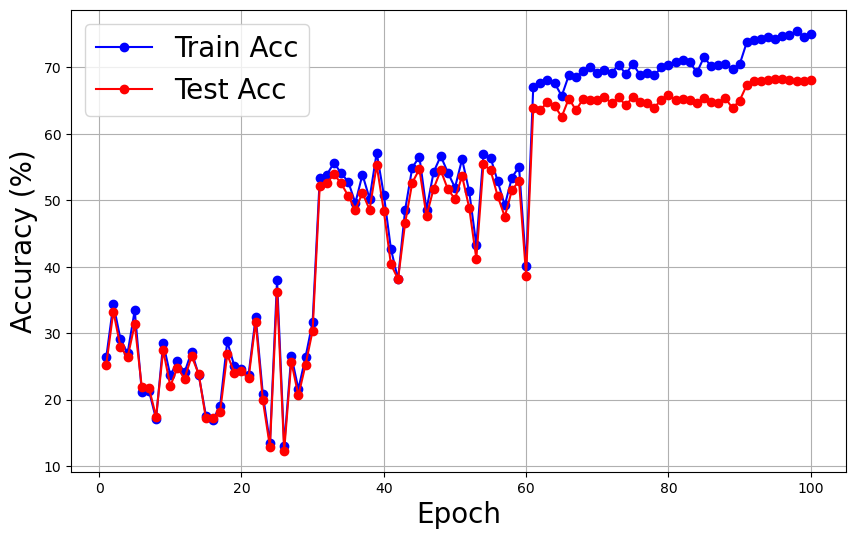

In [19]:
# Initialize lists to store train and test accuracies
epochs = []
train_accs = []
test_accs = []

# Path to your .out file
out_file = '/data/home/huq/MLHospital/log_defense/L1_0.0013/resnet18_shadow.out'

# Regular expression pattern to match the desired lines
pattern = r'Train Epoch: (\d+),.*Train Acc: ([\d\.]+), Test Acc: ([\d\.]+)'

# Read the .out file
with open(out_file, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            epochs.append(int(match.group(1)))
            train_accs.append(float(match.group(2)))
            test_accs.append(float(match.group(3)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label='Train Acc', color='blue', marker='o')
plt.plot(epochs, test_accs, label='Test Acc', color='red', marker='o')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=20)
# plt.title('Training and Testing Accuracy')
plt.legend(fontsize=20)
plt.grid(True)
# plt.savefig("/data/home/huq/MLHospital/figs/nomal_acc_epoch.pdf")
plt.show()


# Trade off

In [40]:
import re

def extract_acc(file_path):
    """从densenet121_target.out文件中提取acc."""
    acc = None
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]  # 过滤掉空行
        # 倒数第二行可能是我们需要的那一行
        match = re.search(r"Test Acc: (\d+\.\d+)", lines[-2])
        if match:
            acc = round(float(match.group(1)) / 100, 3)
    return acc

def extract_attack_acc(file_path, attack_type):
    """根据攻击方法，从相应的文件中提取attack acc."""
    attack_acc = None
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]  # 过滤掉空行
        if attack_type == 'black-box':
            match = re.search(r"Overall Test Acc: (\d+\.\d+)", lines[-1])
            if match:
                attack_acc = round(float(match.group(1)) / 100, 3)
        elif attack_type in ['correct', 'confidence', 'entropy', 'modified entropy','loss']:
            last_lines = lines[-10:]
            patterns = {
                'correct': r"correct test acc:(\d+\.\d+)",
                'confidence': r"confidence test acc:(\d+\.\d+)",
                'entropy': r"entropy test acc:(\d+\.\d+)",
                'modified entropy': r"modified entropy test acc:(\d+\.\d+)",
                'loss': r"cross entropy loss test acc:(\d+\.\d+)"
            }
            for line in last_lines:
                match = re.search(patterns[attack_type], line)
                if match:
                    attack_acc = round(float(match.group(1)), 3)
                    break
        elif attack_type in ['grid_w_l1', 'grid_w_l2', 'grid_w_Mean']:
            patterns = {
                'grid_w_l1': r"grid_w_l1_test acc:(\d+\.\d+)",
                'grid_w_l2': r"grid_w_l2_test acc:(\d+\.\d+)",
                'grid_w_Mean': r"grid_w_Mean_test acc:(\d+\.\d+)"
            }
            for line in lines:
                match = re.search(patterns[attack_type], line)
                if match:
                    attack_acc = round(float(match.group(1)), 3)
                    break
        elif attack_type == 'rotation':
            for line in lines:
                match = re.search(r"Epoch: 5, Overall Test Acc: (\d+\.\d+)", line)
                if match:
                    attack_acc = round(float(match.group(1)) / 100, 3)
                    # print(attack_acc)
                    break
        elif attack_type == 'translation':
            for line in lines[::-1]:
                match = re.search(r"Epoch: 5, Overall Test Acc: (\d+\.\d+)", line)
                if match:
                    attack_acc = round(float(match.group(1)) / 100, 3)
                    # print(attack_acc)
                    break
    return 2 * attack_acc - 1
    # return attack_acc


In [41]:
model_name="resnet18"
# model_name="densenet121"
def get_defense_results(base_dir, attack_type):
    """遍历目录获取所有防御方法及其超参数下的acc和attack acc，包括无防御的结果."""
    results = {}
    normal_acc = None  # 用于存储无防御 (Normal) 的 acc 值
    normal_attack_acc = None  # 用于存储无防御 (Normal) 的 attack acc 值
    
    for folder_name in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, folder_name)):
            if folder_name == "Normal":
                # 处理无防御的情况
                acc_file = os.path.join(base_dir, folder_name, f'{model_name}_target.out')
                normal_acc = extract_acc(acc_file)
                attack_acc_file = None
                if attack_type == 'black-box':
                    attack_acc_file = os.path.join(base_dir, folder_name, f'black-box_{model_name}.out')
                elif attack_type in ['correct', 'confidence', 'entropy', 'modified entropy','loss']:
                    attack_acc_file = os.path.join(base_dir, folder_name, f'metric-based_{model_name}.out')
                elif attack_type in ['grid_w_l1', 'grid_w_l2', 'grid_w_Mean']:
                    attack_acc_file = os.path.join(base_dir, folder_name, f'white-box_{model_name}.out')
                elif attack_type in ['rotation', 'translation']:
                    attack_acc_file = os.path.join(base_dir, folder_name, f'augmentation_{model_name}.out')
                normal_attack_acc = extract_attack_acc(attack_acc_file, attack_type)
                continue  # 跳过进入正常处理流程
            
            defense_method, hyperparam = folder_name.split('_')
            acc_file = os.path.join(base_dir, folder_name, f'{model_name}_target.out')
            acc = extract_acc(acc_file)
            attack_acc_file = None
            if attack_type == 'black-box':
                attack_acc_file = os.path.join(base_dir, folder_name, f'black-box_{model_name}.out')
            elif attack_type in ['correct', 'confidence', 'entropy', 'modified entropy','loss']:
                attack_acc_file = os.path.join(base_dir, folder_name, f'metric-based_{model_name}.out')
            elif attack_type in ['grid_w_l1', 'grid_w_l2', 'grid_w_Mean']:
                attack_acc_file = os.path.join(base_dir, folder_name, f'white-box_{model_name}.out')
            elif attack_type in ['rotation', 'translation']:
                attack_acc_file = os.path.join(base_dir, folder_name, f'augmentation_{model_name}.out')
                # print(attack_acc_file)
            attack_acc = extract_attack_acc(attack_acc_file, attack_type)
            
            if defense_method not in results:
                results[defense_method] = []
            results[defense_method].append((float(hyperparam), acc, attack_acc))
    
    # 按超参数从大到小排序
    for defense_method in results:
        results[defense_method].sort(reverse=True, key=lambda x: x[0])
    
    # 将无防御的结果单独返回
    return results, normal_acc, normal_attack_acc


In [42]:
import matplotlib.pyplot as plt

def plot_all_results_as_subplots(results_dict, normal_acc_dict, save_path=None):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    # 攻击类型作为标题和轴的标签
    attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'loss', 'translation', 'rotation']
    # attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'grid_w_l1', 'grid_w_l2', 'grid_w_Mean']
    
    color_map = {
        'Ours': 'cyan',               # 青色
        'AdvReg': 'blue',           # 蓝色
        'CCL': 'green',             # 绿色
        'ConfidencePenalty': 'orange', # 橙色
        'Dropout': 'red',           # 红色
        'L1': 'purple',            # 深紫色
        'L2': 'magenta',            # 洋红色
        'LabelSmoothing': 'brown',  # 棕色
        'MixupMMD': 'pink',         # 粉色
        'RelaxLoss': 'gray',        # 灰色
    }
    
    # 逐个子图绘制每种攻击类型的结果
    for i, attack_type in enumerate(attack_types):
        row = i // 4
        col = i % 4
        ax = axs[row, col]
        
        results = results_dict.get(attack_type, {})
        all_accs = []
        all_attack_accs = []
        
        for defense_method, data_points in results.items():
            hyperparams, accs, attack_accs = zip(*data_points)
            all_accs.extend(accs)
            all_attack_accs.extend(attack_accs)
            color = color_map.get(defense_method)
            ax.plot(accs, attack_accs, marker='o', linestyle='-', label=defense_method, color=color)
        
        # 绘制无防御的结果为垂直虚线
        normal_acc = normal_acc_dict.get(attack_type, {}).get('acc', None)
        normal_attack_acc = normal_acc_dict.get(attack_type, {}).get('attack_acc', None)
        
        if normal_acc is not None and normal_attack_acc is not None:
            ax.axvline(x=normal_acc, color='r', linestyle='--', label='_nolegend_')  # 隐藏虚线的图例
            normal_marker = ax.scatter(normal_acc, normal_attack_acc, color='black', marker='x', s=200, label='No Defense', zorder=5)  # 用叉叉标记
        
        ax.set_title(attack_type.capitalize(),fontsize=15)
        ax.grid(True,alpha=0.2)
        
        # 确保所有点都在图范围内并设置适当的边距
        if all_accs and all_attack_accs:
            x_min, x_max = min(all_accs + [normal_acc]), max(all_accs + [normal_acc])
            y_min, y_max = min(all_attack_accs + [normal_attack_acc]), max(all_attack_accs + [normal_attack_acc])
            
            # 根据数据范围设置轴范围，并增加一定边距
            x_margin = (x_max - x_min) * 0.05  # 5%的边距
            y_margin = (y_max - y_min) * 0.05  # 5%的边距
            ax.set_xlim(x_min - x_margin, x_max + x_margin)
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # 设置x轴和y轴的标签
    for ax in axs[1, :]:  # 仅在第二行显示x轴标签
        ax.set_xlabel('ACC',fontsize=15)
    for ax in axs[:, 0]:  # 仅在第一列显示y轴标签
        ax.set_ylabel('Attack Advantage',fontsize=15)
    
    # 公共图例
    handles, labels = axs[0, 0].get_legend_handles_labels()
    # 将 'Ours' 移到最左边，'No Defense' 移到最右边
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: ('Ours' not in x[1], x[1] == 'No Defense', x[1]))
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    fig.legend(sorted_handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=11, fontsize=12)

    plt.tight_layout()
    # 如果提供了保存路径，则保存为 PDF
    if save_path:
        fig.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

# # 假设results_dict已经通过之前的步骤生成
# # results_dict = { 'black-box': ..., 'correct': ..., ...}
# plot_all_results_as_subplots(results_dict)


{'black-box': {'L2+Ours': [(2.5, 0.433, 0.29000000000000004), (2.3, 0.446, 0.3759999999999999), (2.0, 0.454, 0.476), (1.0, 0.461, 0.6659999999999999)], 'L1+Ours': [(2.03, 0.458, 0.20999999999999996), (2.0, 0.461, 0.21799999999999997), (1.9, 0.462, 0.264), (1.85, 0.463, 0.276), (1.8, 0.468, 0.31200000000000006), (1.7, 0.469, 0.3480000000000001), (1.5, 0.47, 0.3919999999999999), (1.4, 0.471, 0.42599999999999993), (1.3, 0.471, 0.46599999999999997), (1.1, 0.474, 0.488), (1.0, 0.474, 0.548)], 'L2': [(0.015, 0.426, 0.21199999999999997), (0.013, 0.443, 0.28200000000000003), (0.012, 0.456, 0.32600000000000007), (0.011, 0.461, 0.3859999999999999), (0.01, 0.465, 0.474)], 'L1': [(0.001, 0.436, 0.06000000000000005), (0.0008, 0.452, 0.1479999999999999), (0.0007, 0.453, 0.20399999999999996)]}, 'correct': {'L2+Ours': [(2.5, 0.433, 0.4059999999999999), (2.3, 0.446, 0.48), (2.0, 0.454, 0.518), (1.0, 0.461, 0.544)], 'L1+Ours': [(2.03, 0.458, 0.3600000000000001), (2.0, 0.461, 0.3720000000000001), (1.9, 0

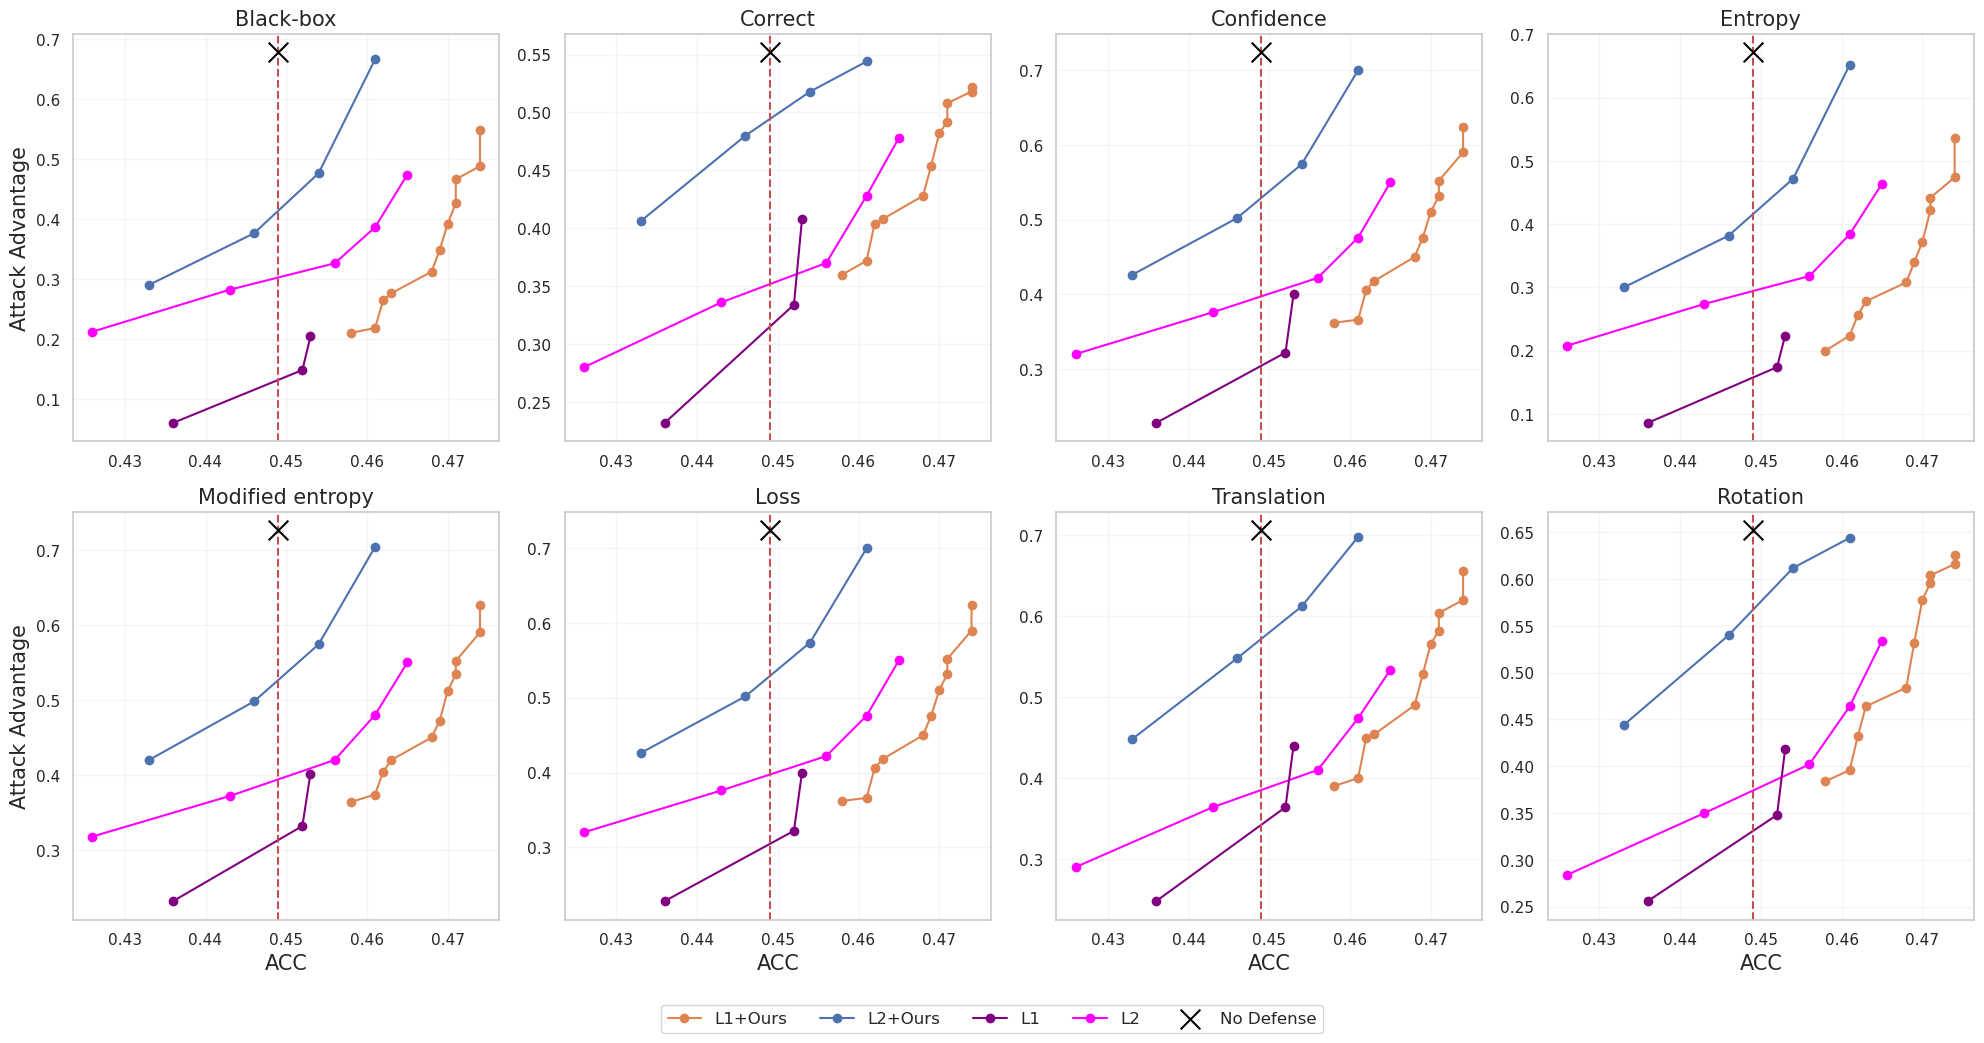

In [43]:
def main(base_dir):
    attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'loss', 'translation', 'rotation']
    # attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'grid_w_l1', 'grid_w_l2', 'grid_w_Mean']
    
    results={}
    results_normal={}
    for attack_type in attack_types:
        results_normal[attack_type]={}
        results[attack_type], results_normal[attack_type]['acc'], results_normal[attack_type]['attack_acc'] = get_defense_results(base_dir, attack_type)
        # plot_results(results, attack_type)
    print(results)
    plot_all_results_as_subplots(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100_resnet18.pdf')
    # plot_all_results_as_subplots(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100_neg_test.pdf')
    # plot_all_results_as_subplots(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100++.pdf')
    # plot_all_results_as_subplots(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar10_dense121.pdf')
    # plot_all_results_as_subplots(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100_resnet18.pdf')
    

# 使用该脚本时，指定你的日志文件的基目录

base_dir = '/data/home/huq/MLHospital/log_defense_cifar100_resnet18_plot'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar100'
# base_dir = '/data/home/huq/MLHospital/log_defense_neg_test_100'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar100'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar100_ablation'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar10_ablation'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar10_dense121_rename'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar100_resnet18_plot'
main(base_dir)


# Hyperparameter

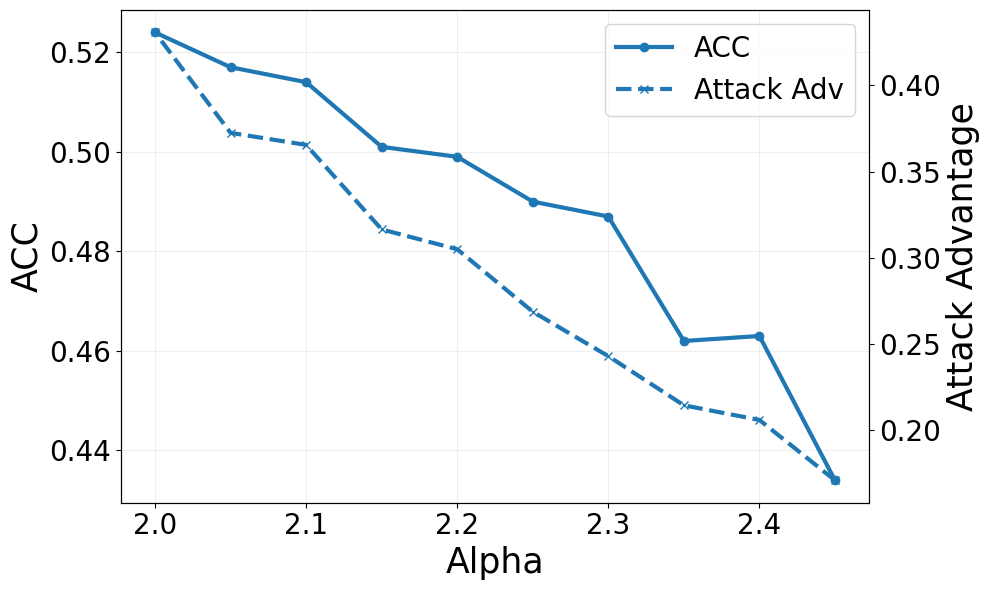

In [15]:
# import matplotlib.pyplot as plt

# def plot_acc_vs_hyperparams(results_dict):
#     # plt.figure(figsize=(10, 6))

#     # for attack_type, defense_data in results_dict.items():
#     #     for defense_method, data_points in defense_data.items():
#     #         hyperparams, accs, _ = zip(*data_points)
#     #         plt.plot(hyperparams, accs, marker='o', label=f"{defense_method} - {attack_type}")
#     defense_methods = set()
#     for attack_type, methods in results_dict.items():
#         defense_methods.update(methods.keys())
#     avg_results = {method: [] for method in defense_methods}
    
#     # 计算每种防御方法的平均 attack acc
#     for attack_type, methods in results_dict.items():
#         # print(attack_type)
#         # print(methods)
#         for method, data in methods.items():
#             hyperparams, accs, attack_accs = zip(*data)
#             avg_results[method].append((hyperparams, accs, attack_accs))
    
#     # 绘制图形
#     plt.figure(figsize=(10, 6))
#     for method, data_points in avg_results.items():
#         # 提取平均 `ACC` 和 `attack acc` 数据
#         hyperparams, accs, attack_accs = zip(*data_points)
#         hyperparams=np.mean(np.array(hyperparams),axis=0)
#         avg_accs=np.mean(np.array(accs),axis=0)
#         avg_attack_accs=np.mean(np.array(attack_accs),axis=0)
#         # print(avg_accs)
#         plt.plot(hyperparams, avg_accs, marker='o', linestyle='-', label=method,linewidth=3)
        
#     # plt.xlabel('Epoch',fontsize=25)
#     plt.xlabel('Alpha',fontsize=25)
#     plt.ylabel('ACC',fontsize=25)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     # plt.title('ACC vs. Hyperparameters')
#     # plt.legend(loc='best',fontsize=25)
#     plt.grid(True,alpha=0.2)
#     plt.tight_layout()
#     plt.savefig("/data/home/huq/MLHospital/figs/alpha_acc_100.pdf")
#     plt.show()

# def plot_attack_acc_vs_hyperparams(results_dict):
#     # plt.figure(figsize=(10, 6))
#     defense_methods = set()
#     for attack_type, methods in results_dict.items():
#         defense_methods.update(methods.keys())
#     avg_results = {method: [] for method in defense_methods}
    
#     # 计算每种防御方法的平均 attack acc
#     for attack_type, methods in results_dict.items():
#         # print(attack_type)
#         # print(methods)
#         for method, data in methods.items():
#             hyperparams, accs, attack_accs = zip(*data)
#             avg_results[method].append((hyperparams, accs, attack_accs))
    
#     # 绘制图形
#     plt.figure(figsize=(10, 6))
#     for method, data_points in avg_results.items():
#         # 提取平均 `ACC` 和 `attack acc` 数据
#         hyperparams, accs, attack_accs = zip(*data_points)
#         hyperparams=np.mean(np.array(hyperparams),axis=0)
#         avg_accs=np.mean(np.array(accs),axis=0)
#         avg_attack_accs=np.mean(np.array(attack_accs),axis=0)
#         # print(avg_accs)
#         plt.plot(hyperparams, avg_attack_accs, marker='o', linestyle='-', label=method,linewidth=3)

#     # plt.xlabel('Epoch',fontsize=25)
#     plt.xlabel('Alpha',fontsize=25)
#     plt.ylabel('Attack Advantage',fontsize=25)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     # plt.title('Attack ACC vs. Hyperparameters')
#     # plt.legend(loc='best',fontsize=25)
#     plt.grid(True,alpha=0.2)
#     plt.tight_layout()
#     plt.savefig("/data/home/huq/MLHospital/figs/alpha_attack_adv_100.pdf")
#     plt.show()

# # 调用函数来绘制图形
# def main(base_dir):
#     attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'loss', 'translation', 'rotation']
#     # attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'grid_w_l1', 'grid_w_l2', 'grid_w_Mean']
    
#     results = {}
#     results_normal = {}
#     for attack_type in attack_types:
#         results_normal[attack_type] = {}
#         results[attack_type], results_normal[attack_type]['acc'], results_normal[attack_type]['attack_acc'] = get_defense_results(base_dir, attack_type)
    
#     # 绘制 acc 和 attack acc 的图
#     plot_acc_vs_hyperparams(results)
#     plot_attack_acc_vs_hyperparams(results)

# base_dir = '/data/home/huq/MLHospital/log_defense_alpha_cifar100'
# # base_dir = '/data/home/huq/MLHospital/log_defense_epoch'
# main(base_dir)


import matplotlib.pyplot as plt
import numpy as np

def plot_combined_acc_vs_attack_adv(results_dict):
    defense_methods = set()
    for attack_type, methods in results_dict.items():
        defense_methods.update(methods.keys())
    avg_results = {method: [] for method in defense_methods}
    
    # 计算每种防御方法的平均 acc 和 attack acc
    for attack_type, methods in results_dict.items():
        for method, data in methods.items():
            hyperparams, accs, attack_accs = zip(*data)
            avg_results[method].append((hyperparams, accs, attack_accs))
    
    # 绘制图形
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax2 = ax1.twinx()  # 创建第二个纵坐标轴
    
    for method, data_points in avg_results.items():
        # 提取平均 `ACC` 和 `attack acc` 数据
        hyperparams, accs, attack_accs = zip(*data_points)
        hyperparams = np.mean(np.array(hyperparams), axis=0)
        avg_accs = np.mean(np.array(accs), axis=0)
        avg_attack_accs = np.mean(np.array(attack_accs), axis=0)

        # 在第一个坐标轴上绘制 `ACC`
        ax1.plot(hyperparams, avg_accs, marker='o', linestyle='-', label=f"ACC", linewidth=3)

        # 在第二个坐标轴上绘制 `Attack Advantage`
        ax2.plot(hyperparams, avg_attack_accs, marker='x', linestyle='--', label=f"Attack Adv", linewidth=3)
    
    # 设置第一个坐标轴 (ACC)
    ax1.set_xlabel('Alpha', fontsize=25)
    # ax1.set_xlabel('Epoch', fontsize=25)
    ax1.set_ylabel('ACC', fontsize=25)
    ax1.tick_params(axis='y', labelsize=20)
    
    # 设置第二个坐标轴 (Attack Advantage)
    ax2.set_ylabel('Attack Advantage', fontsize=25)
    ax2.tick_params(axis='y', labelsize=20)
    
    # 设置刻度和图例
    ax1.tick_params(axis='x', labelsize=20)
    ax1.grid(True, alpha=0.2)
    
    # 合并图例
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='best', fontsize=20)
    # ax1.legend(handles1 + handles2, labels1 + labels2, loc='best', bbox_to_anchor=(1.0, 0.5), fontsize=20)

    plt.tight_layout()
    plt.savefig("/data/home/huq/MLHospital/figs/alpha_combined_acc_attack_adv_100.pdf")
    # plt.savefig("/data/home/huq/MLHospital/figs/epoch_combined_acc_attack_adv_100.pdf")
    plt.show()

# 调用函数来绘制图形
def main(base_dir):
    attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'loss', 'translation', 'rotation']
    
    results = {}
    results_normal = {}
    for attack_type in attack_types:
        results_normal[attack_type] = {}
        results[attack_type], results_normal[attack_type]['acc'], results_normal[attack_type]['attack_acc'] = get_defense_results(base_dir, attack_type)
    
    # 绘制合并的图形
    plot_combined_acc_vs_attack_adv(results)

base_dir = '/data/home/huq/MLHospital/log_defense_alpha_cifar100'
# base_dir = '/data/home/huq/MLHospital/log_defense_epoch'
main(base_dir)


# Ablation

{'black-box': {'L2+Ours': [(2.5, 0.433, 0.29000000000000004), (2.3, 0.446, 0.3759999999999999), (2.0, 0.454, 0.476), (1.0, 0.461, 0.6659999999999999)], 'L1+Ours': [(2.03, 0.458, 0.20999999999999996), (2.0, 0.461, 0.21799999999999997), (1.9, 0.462, 0.264), (1.85, 0.463, 0.276), (1.8, 0.468, 0.31200000000000006), (1.7, 0.469, 0.3480000000000001), (1.5, 0.47, 0.3919999999999999), (1.4, 0.471, 0.42599999999999993), (1.3, 0.471, 0.46599999999999997), (1.1, 0.474, 0.488), (1.0, 0.474, 0.548)], 'L2': [(0.015, 0.426, 0.21199999999999997), (0.013, 0.443, 0.28200000000000003), (0.012, 0.456, 0.32600000000000007), (0.011, 0.461, 0.3859999999999999), (0.01, 0.465, 0.474)], 'L1': [(0.001, 0.436, 0.06000000000000005), (0.0008, 0.452, 0.1479999999999999), (0.0007, 0.453, 0.20399999999999996)]}, 'correct': {'L2+Ours': [(2.5, 0.433, 0.4059999999999999), (2.3, 0.446, 0.48), (2.0, 0.454, 0.518), (1.0, 0.461, 0.544)], 'L1+Ours': [(2.03, 0.458, 0.3600000000000001), (2.0, 0.461, 0.3720000000000001), (1.9, 0

/tmp/ipykernel_697054/1589832065.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(avg_normal_acc, avg_normal_attack_acc, color='black', marker='x', s=100, edgecolor='k', label='Base')


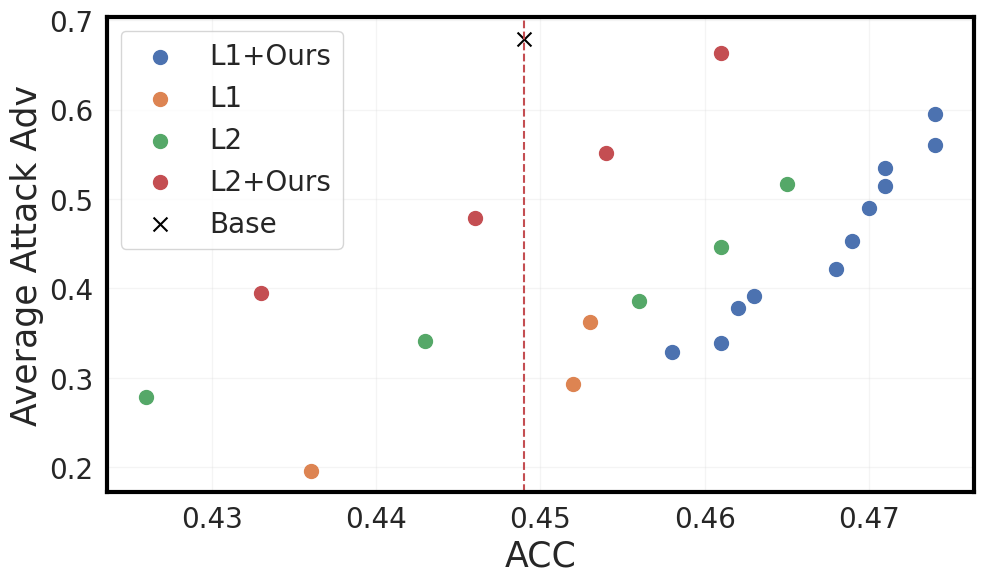

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_average_tradeoff(results_dict, normal_acc_dict, save_path=None):
    # 收集所有防御方法及其对应的平均 attack acc
    defense_methods = set()
    for attack_type, methods in results_dict.items():
        defense_methods.update(methods.keys())

    # 初始化数据结构以存储每种防御方法的平均结果
    # accs=None
    avg_results = {method: [] for method in defense_methods}
    
    # 计算每种防御方法的平均 attack acc
    for attack_type, methods in results_dict.items():
        # print(attack_type)
        # print(methods)
        for method, data in methods.items():
            hyperparams, accs, attack_accs = zip(*data)
            avg_results[method].append((accs, attack_accs))
    
    # # 从 method 提取 lambda 值并排序
    # sorted_methods = sorted(avg_results.keys(), key=lambda x: float(x.split('=')[1]))
    # # 颜色渐变：根据 sorted_methods 的长度生成渐变色
    # colors = cm.Blues(np.linspace(0.3, 1, len(sorted_methods)))
    # # colors=['blue', 'cyan', 'green', 'yellow']

    
    # # 绘制每条线
    # plt.figure(figsize=(10, 6))
    # for i, method in enumerate(sorted_methods):
    #     data_points = avg_results[method]
        
    #     # 提取 `ACC` 和 `attack acc` 数据
    #     accs, attack_accs = zip(*data_points)
    #     avg_accs = np.mean(np.array(accs), axis=0)
    #     avg_attack_accs = np.mean(np.array(attack_accs), axis=0)
        
    #     # 使用渐变色绘制线条
    #     plt.plot(avg_accs, avg_attack_accs, linestyle='-', color=colors[i], label=method, linewidth=3)
    
    # 绘制图形
    plt.figure(figsize=(10, 6))
    for method, data_points in avg_results.items():
        # 提取平均 `ACC` 和 `attack acc` 数据
        accs, attack_accs = zip(*data_points)
        avg_accs=np.mean(np.array(accs),axis=0)
        avg_attack_accs=np.mean(np.array(attack_accs),axis=0)
        print(avg_accs)
        # plt.plot(avg_accs, avg_attack_accs, marker='o', linestyle='-', label=method)
        # plt.plot(avg_accs, avg_attack_accs, label=method, linewidth=4)
        plt.scatter(avg_accs, avg_attack_accs, label=method, s=100)  # s 参数用于调整点的大小

    
    # 绘制无防御的结果
    normal_accs=[]
    normal_attack_accs=[]
    for attack_type in normal_acc_dict.keys():
        normal_acc = normal_acc_dict[attack_type]['acc']
        normal_attack_acc = normal_acc_dict[attack_type]['attack_acc']
        normal_accs.append(normal_acc)
        normal_attack_accs.append(normal_attack_acc)
    avg_normal_acc = np.mean(normal_accs)
    avg_normal_attack_acc = np.mean(normal_attack_accs)
    plt.axvline(x=avg_normal_acc, color='r', linestyle='--', label='_nolegend_')
    plt.scatter(avg_normal_acc, avg_normal_attack_acc, color='black', marker='x', s=100, edgecolor='k', label='Base')

    # 设置标签和标题
    plt.xlabel('ACC',fontsize=25)
    plt.ylabel('Average Attack Adv',fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.title('Average Utility-Privacy Trade-off')
    plt.grid(True, alpha=0.2)

    # 公共图例
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best',fontsize=20)
    
    # # 获取当前的句柄和标签
    # handles, labels = plt.gca().get_legend_handles_labels()
    # # 提取 lambda 数值并排序，忽略不含 'lambda=' 的标签
    # sorted_pairs = sorted(
    #     [(label, handle) for label, handle in zip(labels, handles) if 'lambda=' in label], 
    #     key=lambda x: float(x[0].split('=')[1])
    # )
    # # 保留 'base' 标签，并将其插入到 legend 的开头
    # base_pairs = [(label, handle) for label, handle in zip(labels, handles) if 'lambda=' not in label]
    # # 合并 base 和排序后的 lambda
    # sorted_pairs = base_pairs + sorted_pairs
    # # 重新排序 legend
    # sorted_labels, sorted_handles = zip(*sorted_pairs)
    # plt.legend(sorted_handles, sorted_labels, loc='best', fontsize=20)

    # Add a black border around the entire plot
    plt.gca().spines['top'].set_linewidth(3)
    plt.gca().spines['right'].set_linewidth(3)
    plt.gca().spines['left'].set_linewidth(3)
    plt.gca().spines['bottom'].set_linewidth(3)

    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')


    plt.tight_layout()
    # 保存为 PDF 格式
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

# # 调用函数绘制图
# plot_ablation_experiment(results_dict)

def main(base_dir):
    attack_types = ['black-box', 'correct', 'confidence', 'entropy', 'modified entropy', 'loss', 'translation', 'rotation']
    results={}
    results_normal={}
    for attack_type in attack_types:
        results_normal[attack_type]={}
        results[attack_type], results_normal[attack_type]['acc'], results_normal[attack_type]['attack_acc'] = get_defense_results(base_dir, attack_type)
        # plot_results(results, attack_type)
    print(results)
    # plot_average_tradeoff(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar10_ppb.pdf')
    # plot_average_tradeoff(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar10_lambda.pdf')
    plot_average_tradeoff(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100_resnet18_avg.pdf')
    # plot_average_tradeoff(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar100_resnet18_avg.pdf')
    # plot_average_tradeoff(results,results_normal,save_path='/data/home/huq/MLHospital/figs/cifar10_dense121_avg.pdf')

# base_dir = '/data/home/huq/MLHospital/log_defense_PPB'
# base_dir = '/data/home/huq/MLHospital/log_defense_lambda'
base_dir = '/data/home/huq/MLHospital/log_defense_cifar100_resnet18_plot'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar100_resnet18_plot'
# base_dir = '/data/home/huq/MLHospital/log_defense_cifar10_dense121_rename'
main(base_dir)


# Grad gap

In [78]:
def get_target_model(name="resnet18", num_classes=10):
    if name == "resnet18":
        model = torchvision.models.resnet18()
        model.fc = nn.Sequential(nn.Linear(512, 10))
    else:
        raise ValueError("Model not implemented yet :P")
    return model

target_model = get_target_model(name="resnet18", num_classes=10).cuda()
# print(target_model)
for name, m in target_model.named_modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear)):
        print(name)

conv1
bn1
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1.conv1
layer3.1.bn1
layer3.1.conv2
layer3.1.bn2
layer4.0.conv1
layer4.0.bn1
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1.conv1
layer4.1.bn1
layer4.1.conv2
layer4.1.bn2
fc.0


In [ ]:
loaded_grad_gaps = torch.load('/data/home/huq/MLHospital/log_distribution/grad_gaps/grad_gaps_1_1.pth')

for name, grad_gap in loaded_grad_gaps.items():
    grad_gap_values = grad_gap.cpu().numpy().flatten()  # 转为 numpy 数组并展平
    plt.hist(grad_gap_values, bins=50, alpha=0.7)
    plt.title(f'Gradient Gap Distribution for {name}')
    plt.xlabel('Gradient Gap')
    plt.ylabel('Frequency')
    plt.show()

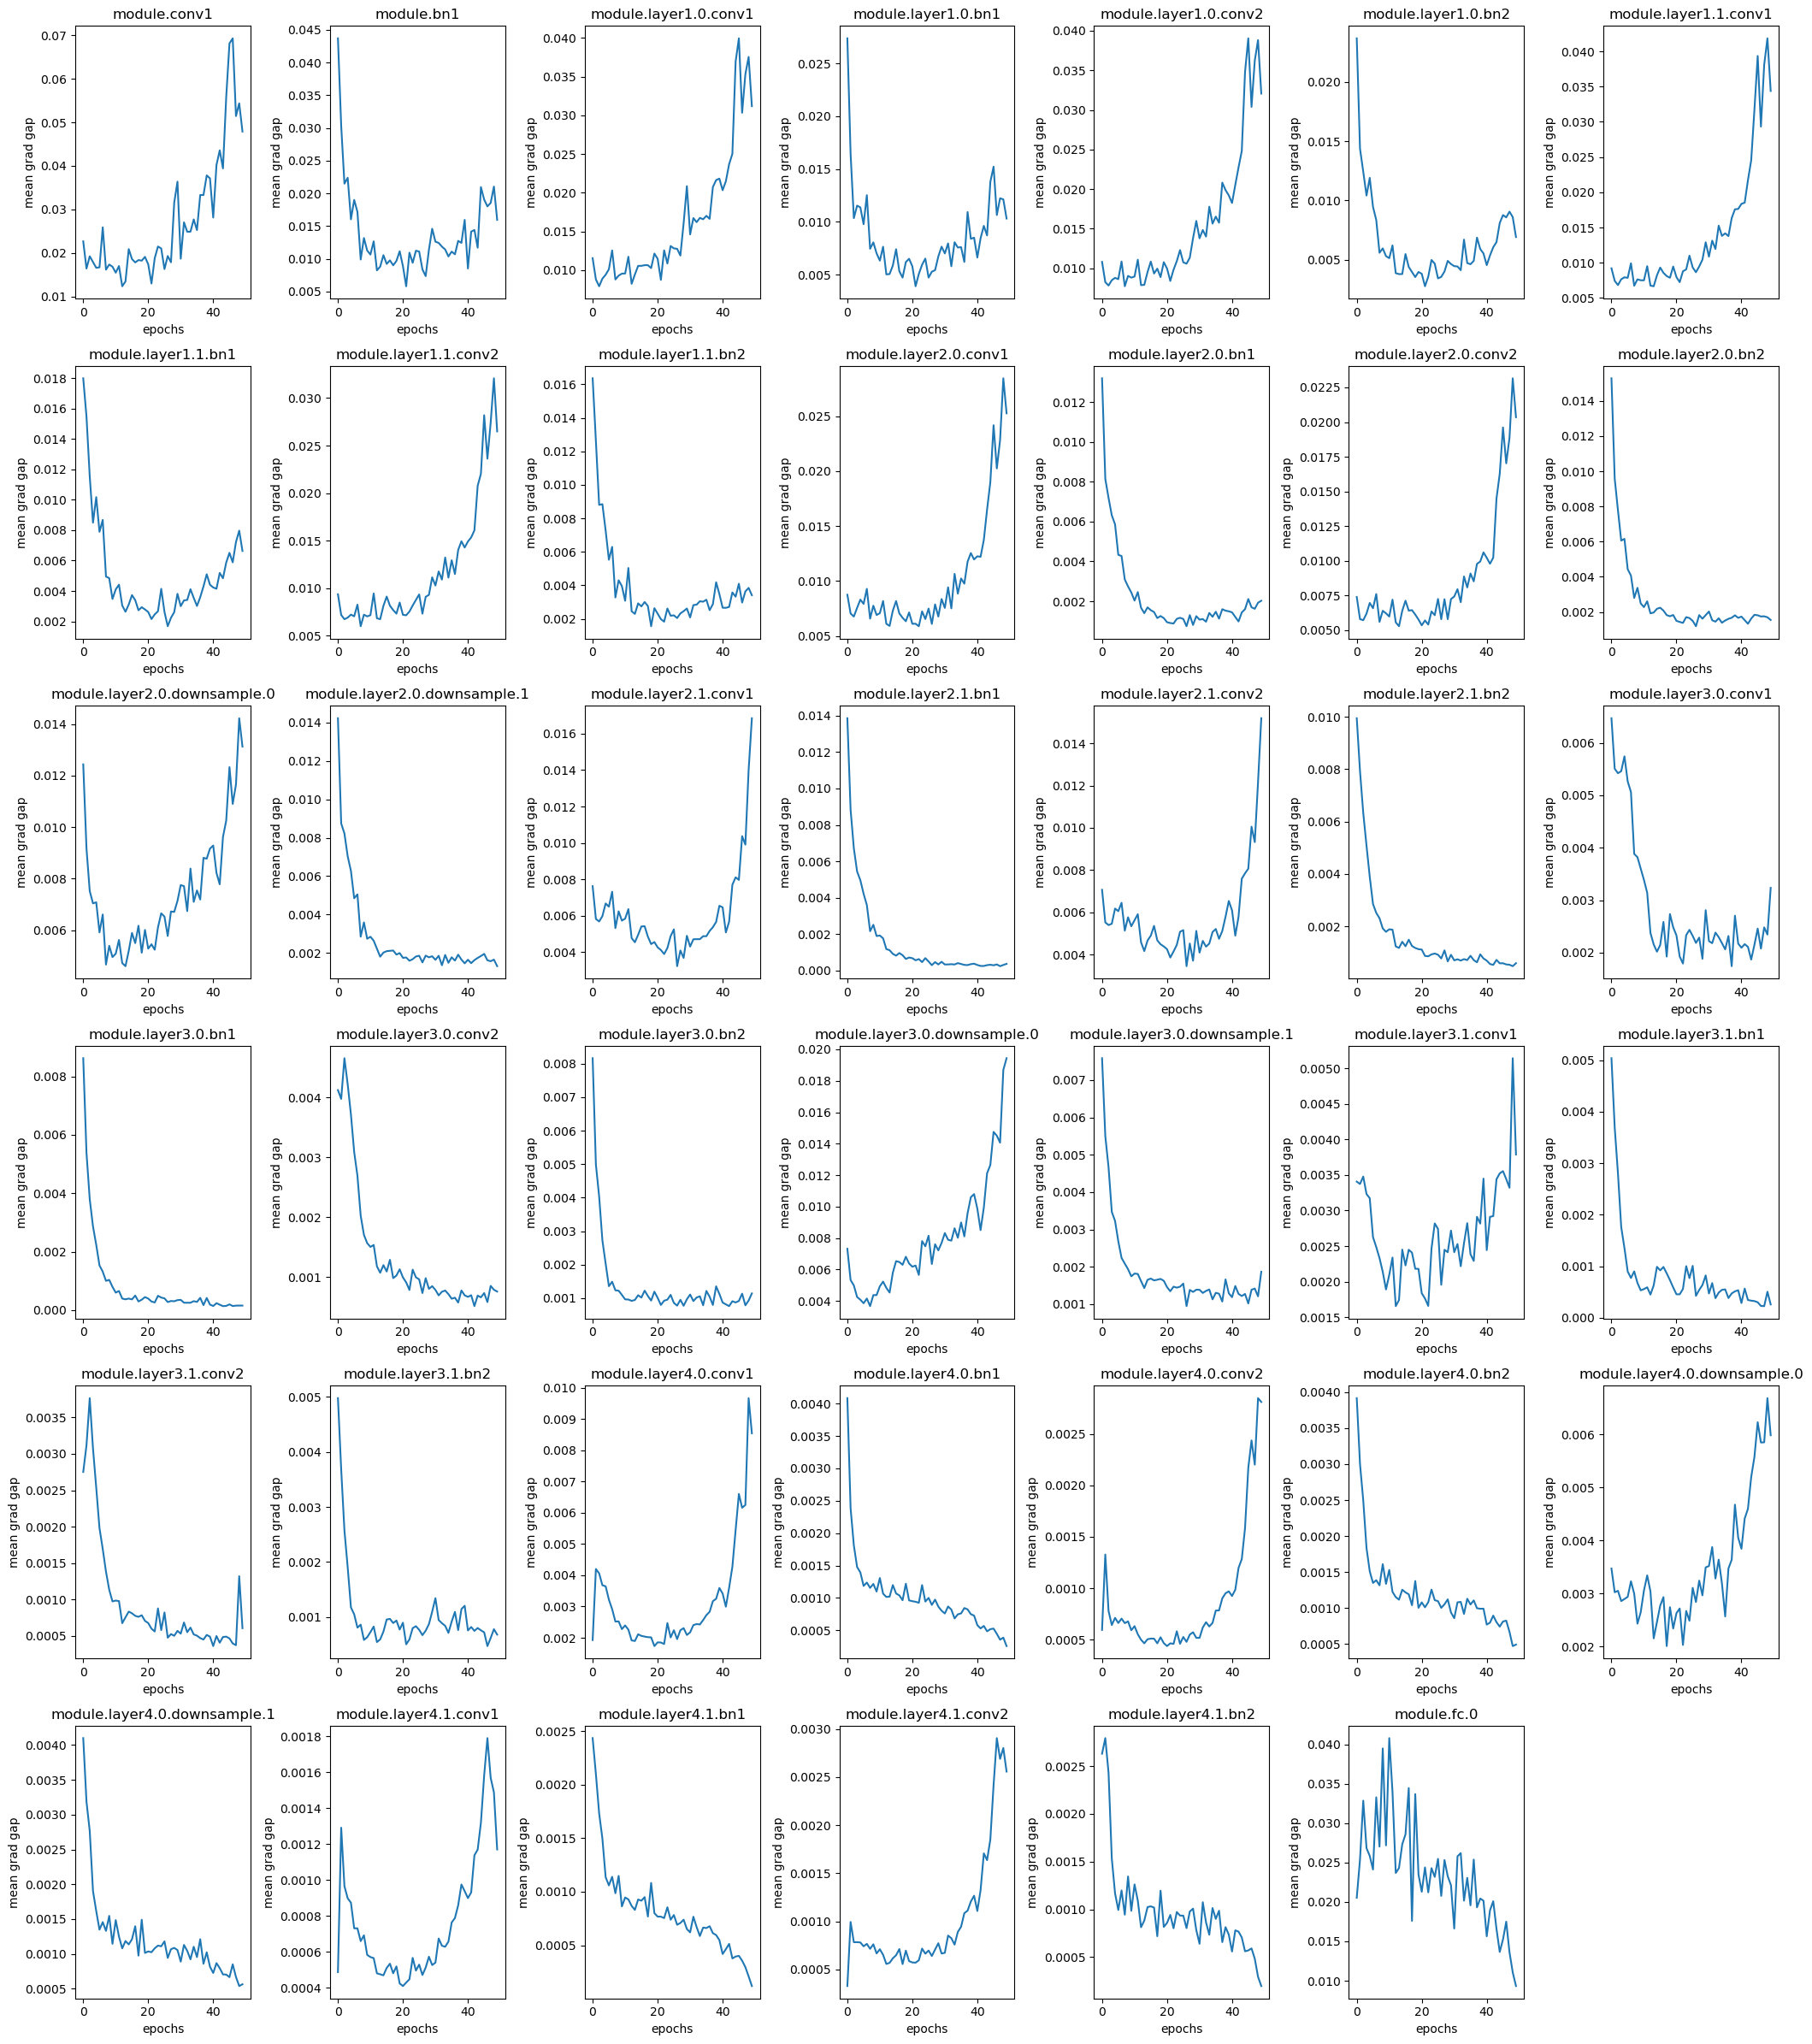

In [61]:
grad_gaps_all_epoch={}
for i in range(1,51):
    # for j in range(1,72,10):
    # loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/adaptive_regs_70100/adaptive_regs_{i}_{j}.pth')
    loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/grad_gaps_0.001_50_1.5/grad_gaps_{i}_1.pth')
    # print(loaded_grad_gaps)
    for name, grad_gap in loaded_grad_gaps.items():
        # grad_gap_values = grad_gap.cpu().numpy().flatten()/1e-5  # 转为 numpy 数组并展平
        grad_gap_values = grad_gap.cpu().numpy().flatten()  # 转为 numpy 数组并展平
        if name not in grad_gaps_all_epoch.keys():
            grad_gaps_all_epoch[name]=[grad_gap_values.mean()]
            # print(0)
        else:
            # print(1)
            grad_gaps_all_epoch[name].append(grad_gap_values.mean())

# for name, grad_gap in grad_gaps_all_epoch.items():
#     # grad_gap_values = grad_gap.cpu().numpy().flatten()  # 转为 numpy 数组并展平
#     # print(grad_gap_values.mean())
#     plt.plot(grad_gap)
#     plt.title(f'Gradient Gap Variation for {name}')
#     plt.xlabel('reg progress')
#     plt.ylabel('mean grad gap')
#     plt.show()

num_plots = len(grad_gaps_all_epoch)
cols = 7  # 每行的列数
rows = 6  # 每列的行数

plt.figure(figsize=(21, rows * 4))  # 调整图形的尺寸，确保每个子图有足够的空间

for i, (name, grad_gap) in enumerate(grad_gaps_all_epoch.items()):
    plt.subplot(rows, cols, i + 1)  # 在网格中创建子图
    plt.plot(grad_gap)
    plt.title(f'{name}')
    plt.xlabel('epochs')
    plt.ylabel('mean grad gap')

plt.tight_layout()  # 调整子图布局，使其在图形区域内适应
plt.savefig("/data/home/huq/MLHospital/figs/grad_gap_epoch_module_ours.pdf")
plt.show()

### Result Existed

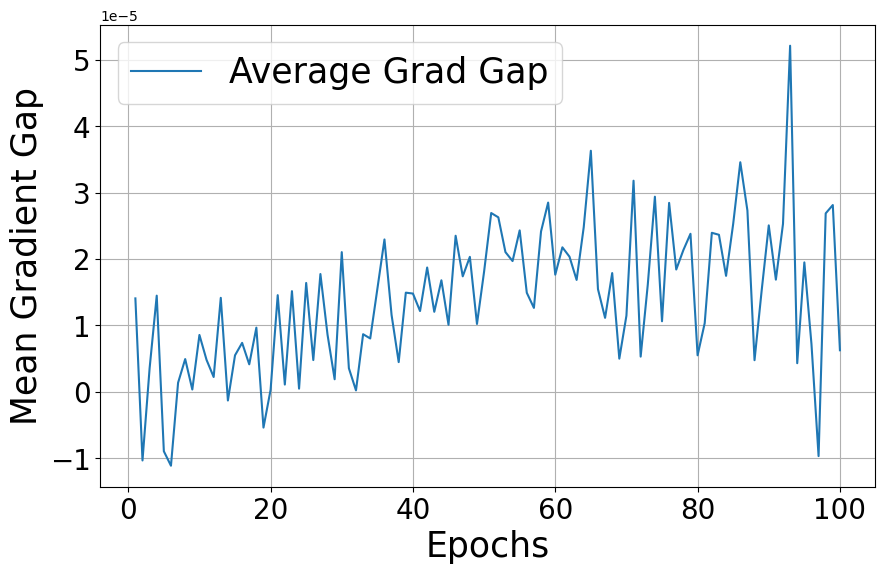

In [59]:
import matplotlib.pyplot as plt
import torch

grad_gaps_all_epoch = {}
num_epochs = 100

# Load and process gradient gap data
for i in range(1, num_epochs + 1):
    loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/grad_gaps_normal_noabs/grad_gaps_{i}_1.pth')
    for name, grad_gap in loaded_grad_gaps.items():
        grad_gap_values = grad_gap.cpu().numpy().flatten()  # Convert to numpy array and flatten
        if name not in grad_gaps_all_epoch:
            grad_gaps_all_epoch[name] = [grad_gap_values]
        else:
            grad_gaps_all_epoch[name].append(grad_gap_values)

# Calculate the average grad_gap across all parameters
all_grad_gaps_mean = []
for epoch in range(num_epochs):
    epoch_total_grad_gaps = 0
    epoch_total_params = 0
    for name in grad_gaps_all_epoch:
        grad_gaps = grad_gaps_all_epoch[name][epoch]
        epoch_total_grad_gaps += grad_gaps.sum()  # Sum the grad_gap values for all parameters
        epoch_total_params += len(grad_gaps)  # Count the number of parameters
    all_grad_gaps_mean.append(epoch_total_grad_gaps / epoch_total_params)  # Compute the overall mean

# Plot the average grad_gap across all parameters
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), all_grad_gaps_mean, label='Average Grad Gap')
# plt.title('Average Gradient Gap Across All Parameters')
plt.xlabel('Epochs',fontsize=25)
plt.ylabel('Mean Gradient Gap',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)
plt.grid(True)
plt.savefig("/data/home/huq/MLHospital/figs/average_grad_gap_noabs_epoch.pdf")
plt.show()


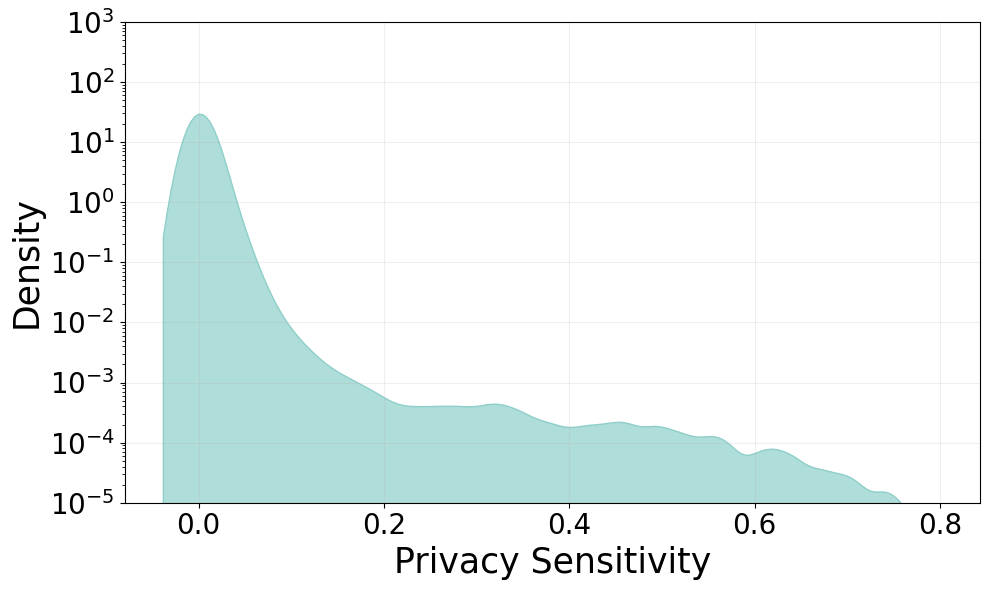

大于0.05的元素占比: 0.23%


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

grad_gaps_last_epoch = []

# Load the grad_gap data for the last epoch
num_epochs = 100
# loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/loss_gap_grad_normal_noabs/loss_gap_grad_{num_epochs}_1.pth')
# loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/grad_gaps_normal_noabs/grad_gaps_{num_epochs}_1.pth')
# loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/loss_gap_grads_normal_noabs_Reg-0.0-0100-10000_0.0.pth')
loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/grad_gaps_normal_noabs_Reg-0.0-0100-10000_0.0.pth')
# loaded_grad_gaps = torch.load(f'/data/home/huq/MLHospital/log_distribution/grad_gaps_ours_Reg-0.001-10050-10000_1.5.pth')

# Collect all grad_gaps from the last epoch
for name, grad_gap in loaded_grad_gaps.items():
    # if "bn" in name:
    grad_gap_values = abs(grad_gap.cpu().numpy().flatten())  # Convert to numpy array and flatten
    grad_gaps_last_epoch.extend(grad_gap_values)  # Add to the list

# Convert to numpy array for easier handling
grad_gaps_last_epoch = np.array(grad_gaps_last_epoch)

# Plot the distribution of grad_gaps using a histogram
plt.figure(figsize=(10, 6))
# plt.hist(grad_gaps_last_epoch, bins=300, alpha=0.7, color='b', label='Privacy Sensitivity Distribution',density=True)
sns.kdeplot(grad_gaps_last_epoch, bw_adjust=40, fill=True, color='#8ECFC9', label='Privacy Sensitivity Distribution', alpha=0.7)

# Alternatively, use a density plot if desired
# import seaborn as sns
# sns.kdeplot(grad_gaps_last_epoch, shade=True, label='Grad Gap Density')

# plt.title('Gradient Gap Distribution (Last Epoch)')
plt.xlabel('Privacy Sensitivity',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.ylim(1e-5,1e3)
# plt.legend(fontsize=25)
plt.grid(True,alpha=0.2)
plt.tight_layout()  # 自动调整布局
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap_grad_distribution_normal.pdf")
plt.show()

#####################
#####################

# 统计大于 0.05 的元素数量
count_above_threshold = np.sum(grad_gaps_last_epoch > 0.05)

# 计算总元素数量
total_count = grad_gaps_last_epoch.size

# 计算占比
proportion = count_above_threshold / total_count

print(f'大于0.05的元素占比: {proportion:.2%}')

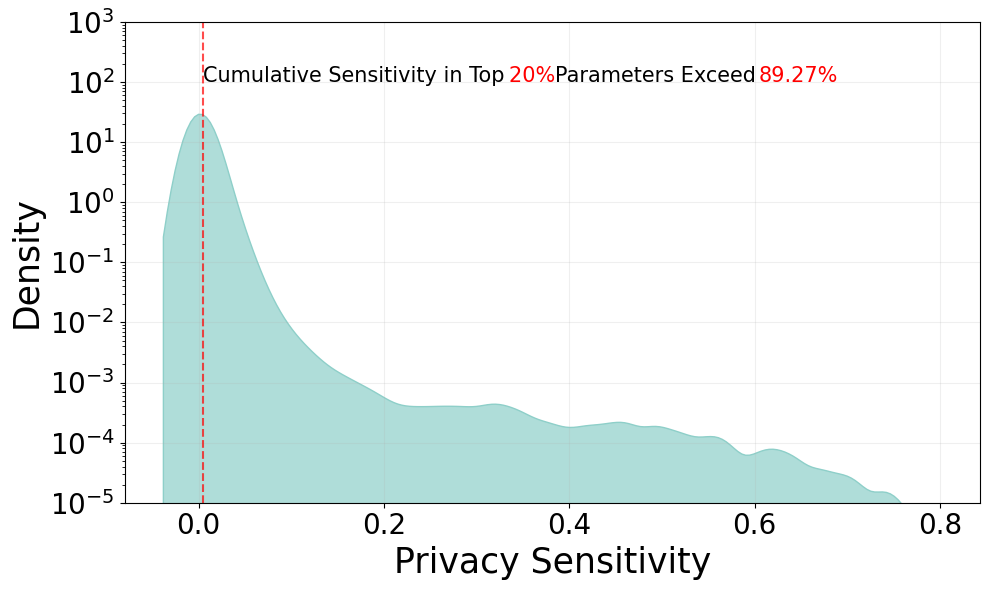

Top 1% cumulative privacy sensitivity proportion: 89.27%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['text.usetex'] = False

# 假设grad_gaps_last_epoch是最后一轮的隐私敏感性差异
grad_gaps_last_epoch = np.array(grad_gaps_last_epoch)

# 1. 对隐私敏感性差异进行排序
sorted_grad_gaps = np.sort(grad_gaps_last_epoch)[::-1]  # 降序排序

# 2. 找到前1%的位置
percent_1_index = int(len(sorted_grad_gaps) * 0.2)

# 3. 计算前1%参数的累计隐私敏感性
cumulative_privacy_sensitivity = np.cumsum(sorted_grad_gaps)
total_privacy_sensitivity = cumulative_privacy_sensitivity[-1]
top_1_cumulative_sensitivity = cumulative_privacy_sensitivity[percent_1_index] / total_privacy_sensitivity

# 4. 绘制隐私敏感性差异的分布图，并标注1%位置
plt.figure(figsize=(10, 6))

# 绘制核密度估计图
sns.kdeplot(grad_gaps_last_epoch, bw_adjust=40, fill=True, color='#8ECFC9', label='Privacy Sensitivity Distribution', alpha=0.7)

# 在图上绘制1%的竖虚线
plt.axvline(sorted_grad_gaps[percent_1_index], color='r', linestyle='--', label='Top 1% Threshold',alpha=0.7)

# 设置图形参数
plt.xlabel('Privacy Sensitivity', fontsize=25)
plt.ylabel('Density', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
plt.ylim(1e-5, 1e3)
plt.grid(True, alpha=0.2)
plt.tight_layout()

# 显示累计隐私敏感性比例
# plt.text(sorted_grad_gaps[percent_1_index], 1e2, f'Cumulative Sensitivity of 20% Parameters Exceed {top_1_cumulative_sensitivity:.2%}', color='r', fontsize=15)
# 添加文字：多次调用 text 来分别显示不同颜色的部分
plt.text(sorted_grad_gaps[percent_1_index], 1e2, 'Cumulative Sensitivity in Top', color='black', fontsize=15)
plt.text(sorted_grad_gaps[percent_1_index] + 0.33, 1e2, '20% ', color='red', fontsize=15)
plt.text(sorted_grad_gaps[percent_1_index] + 0.38, 1e2, 'Parameters Exceed', color='black', fontsize=15)
plt.text(sorted_grad_gaps[percent_1_index] + 0.60, 1e2, f'{top_1_cumulative_sensitivity:.2%}', color='red', fontsize=15)


# 使用 LaTeX 语法在一行内实现不同颜色和加粗
plt.rcParams['text.usetex'] = False
# plt.text(sorted_grad_gaps[percent_1_index], 1e2, 
#          r'Cumulative Sensitivity in Top $\textbf{\textcolor{blue}{10\%}}$ Parameters Exceed $\textbf{\textcolor{orange}{' + f'{top_1_cumulative_sensitivity:.2%}' + '}}$', 
#          fontsize=15)

# # 不使用 LaTeX，直接控制颜色和加粗
# plt.text(sorted_grad_gaps[percent_1_index], 1e2, 
#          f'Cumulative Sensitivity in Top ', fontsize=15)

# # 高亮显示 "10%"，使用蓝色
# plt.text(sorted_grad_gaps[percent_1_index] + 0.05, 1e2, 
#          '10%', fontsize=15, color='blue', fontweight='bold')

# # 普通文本
# plt.text(sorted_grad_gaps[percent_1_index] + 0.15, 1e2, 
#          ' Parameters Exceed ', fontsize=15)

# # 高亮显示累计隐私敏感性，使用橙色
# plt.text(sorted_grad_gaps[percent_1_index] + 0.4, 1e2, 
#          f'{top_1_cumulative_sensitivity:.2%}', fontsize=15, color='orange', fontweight='bold')


# 保存图像
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap_grad_distribution_normal_top20_percent.pdf")
plt.show()

# 输出前1%参数的累计隐私敏感性占比
print(f'Top 1% cumulative privacy sensitivity proportion: {top_1_cumulative_sensitivity:.2%}')


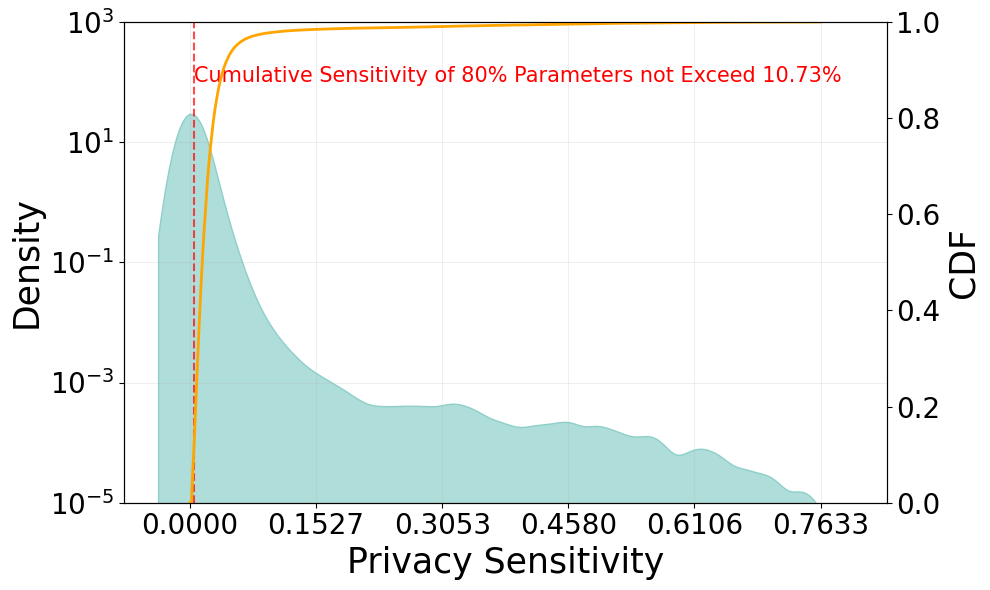

Top 20% cumulative privacy sensitivity proportion: 89.27%


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = False

# 假设 grad_gaps_last_epoch 是最后一轮的隐私敏感性差异
grad_gaps_last_epoch = np.array(grad_gaps_last_epoch)

# 1. 对隐私敏感性差异进行排序
sorted_grad_gaps = np.sort(grad_gaps_last_epoch)[::-1]  # 降序排序

# 2. 找到前20%的位置
percent_1_index = int(len(sorted_grad_gaps) * 0.2)

# 3. 计算前20%参数的累计隐私敏感性
cumulative_privacy_sensitivity = np.cumsum(sorted_grad_gaps)
total_privacy_sensitivity = cumulative_privacy_sensitivity[-1]
top_1_cumulative_sensitivity = cumulative_privacy_sensitivity[percent_1_index] / total_privacy_sensitivity

# 4. 绘制隐私敏感性差异的分布图，并标注20%位置
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制核密度估计图
sns.kdeplot(grad_gaps_last_epoch, bw_adjust=40, fill=True, color='#8ECFC9', label='Privacy Sensitivity Distribution', alpha=0.7, ax=ax1)

# 在图上绘制20%的竖虚线
ax1.axvline(sorted_grad_gaps[percent_1_index], color='r', linestyle='--', label='Top 20% Threshold', alpha=0.7)

# 设置图形参数
ax1.set_xlabel('Privacy Sensitivity', fontsize=25)
ax1.set_ylabel('Density', fontsize=25)
ax1.set_xticks(np.linspace(min(grad_gaps_last_epoch), max(grad_gaps_last_epoch), num=6))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_yscale('log')
ax1.set_ylim(1e-5, 1e3)
ax1.grid(True, alpha=0.2)

# 显示累计隐私敏感性比例
ax1.text(sorted_grad_gaps[percent_1_index], 1e2, f'Cumulative Sensitivity of 80% Parameters not Exceed {1-top_1_cumulative_sensitivity:.2%}', color='r', fontsize=15)

# 添加双 y 轴，绘制 CDF
ax2 = ax1.twinx()

# 绘制 CDF
ax2.plot(sorted_grad_gaps, 1-cumulative_privacy_sensitivity / total_privacy_sensitivity, color='orange', label='CDF', linewidth=2)
ax2.set_ylabel('CDF', fontsize=25)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim(0, 1)

# 保存图像
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap_grad_distribution_with_cdf.pdf")
plt.show()

# 输出前20%参数的累计隐私敏感性占比
print(f'Top 20% cumulative privacy sensitivity proportion: {top_1_cumulative_sensitivity:.2%}')


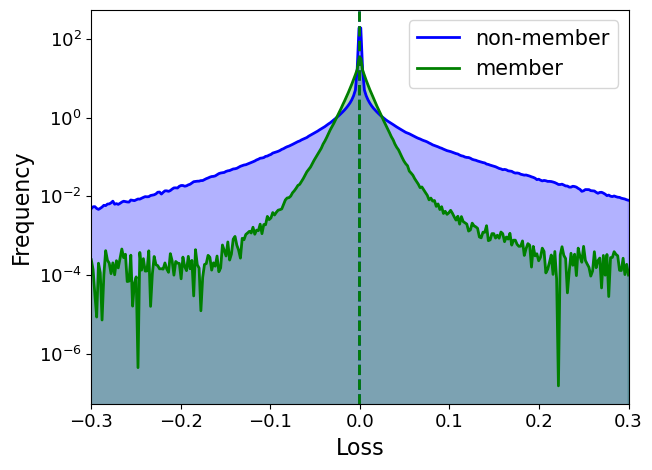

[ 0.04066233  0.02078815  0.0142598  ...  0.01084283  0.00545978
 -0.01971738]
[ 0.36416337  0.31904262  0.36308742 ... -0.00213458 -0.01880636
 -0.0028938 ]


In [101]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os 
import sys
import argparse
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

def plot_hist_line(data1, data2, args):
    member_losses, non_member_losses = data1,data2
    
    # 计算统计量
    mean_non_member = np.mean(non_member_losses)
    var_non_member = np.var(non_member_losses)
    mean_member = np.mean(member_losses)
    var_member = np.var(member_losses)
    
    # 使用核密度估计拟合频率分布
    non_member_kde = gaussian_kde(non_member_losses)
    member_kde = gaussian_kde(member_losses)
    
    x_smooth = np.linspace(args.min_value, args.max_value, 300)
    non_member_density = non_member_kde(x_smooth)
    member_density = member_kde(x_smooth)
    
    plt.plot(x_smooth, non_member_density, color='blue', linestyle='solid', linewidth=2, label='non-member')
    plt.plot(x_smooth, member_density, color='green', linestyle='solid', linewidth=2, label='member')
    
    # 填充曲线下面的区域
    plt.fill_between(x_smooth, non_member_density, color='blue', alpha=0.3)
    plt.fill_between(x_smooth, member_density, color='green', alpha=0.3)

    # 添加虚线
    peak_non_member = x_smooth[np.argmax(non_member_density)]
    peak_member = x_smooth[np.argmax(member_density)]
    plt.axvline(peak_non_member, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(peak_member, color='green', linestyle='dashed', linewidth=2)

    # 添加统计信息
    mean_non_member = np.sum(x_smooth * non_member_density) / np.sum(non_member_density)
    var_non_member = np.sum((x_smooth - mean_non_member) ** 2 * non_member_density) / np.sum(non_member_density)
    mean_member = np.sum(x_smooth * member_density) / np.sum(member_density)
    var_member = np.sum((x_smooth - mean_member) ** 2 * member_density) / np.sum(member_density)
    
    # plt.text(15, 0.15, f'$\\mathbb{{E}}[\\ell]_{{\\mathrm{{mem}}}}={mean_member:.2f}$\n$\\mathrm{{Var}}[\\ell]_{{\\mathrm{{mem}}}}={var_member:.2f}$', fontsize=8, color='black')
    # plt.text(15, 0.1, f'$\\mathbb{{E}}[\\ell]_{{\\mathrm{{non}}}}={mean_non_member:.2f}$\n$\\mathrm{{Var}}[\\ell]_{{\\mathrm{{non}}}}={var_non_member:.2f}$', fontsize=8, color='black')
    
    
    plt.tick_params(axis='both', which='major', labelsize=13)
    # 添加标签、图例和网格
    plt.xlabel('Loss', fontsize=16)
    # plt.xlabel('Min-k%', fontsize=16)
    plt.tight_layout() 
    plt.ylabel('Frequency', fontsize=16)
    plt.tight_layout()
    plt.legend(loc='best', prop={'size': 15})
    # plt.title('Perplexity Distribution for Members and Non-members')
    plt.grid(False)
    plt.xlim(args.min_value, args.max_value)
    plt.yscale('log')
    # plt.ylim(0, args.hight)
    # 保存图形
    plt.savefig(args.output_dir, dpi=300)
    plt.show()
args = argparse.Namespace(
    min_value=-0.5,
    max_value=0.5,
    hight=10,
    output_dir='/data/home/huq/MLHospital/log_distribution'
    )
plot_hist_line(grad_gaps_last_epoch,grad_gaps_last_epoch_1,args)
print(grad_gaps_last_epoch)
print(grad_gaps_last_epoch_1)

### Model Exist

##### grad gap

In [50]:
import torch
import torch.nn as nn

def compute_grad_gap(member_grads, nonmember_grads):
    # 计算梯度的差异，使用每个层的 weight 梯度进行比较
    grad_gaps = {name: (member_grads[name] - nonmember_grads[name]) for name in member_grads.keys()}
    return grad_gaps

class ModelEvaluator:
    def __init__(self, model, criterion, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.device = device

    def evaluate_single_batch(self, member_loader, nonmember_loader, save_path, training_type):
        self.model.eval()  # 设置模型为评估模式

        # 获取一个 batch 的 member 数据
        member_img, member_label = next(iter(member_loader))
        member_img, member_label = member_img.to(self.device), member_label.to(self.device)

        # 获取一个 batch 的 nonmember 数据
        nonmember_img, nonmember_label = next(iter(nonmember_loader))
        nonmember_img, nonmember_label = nonmember_img.to(self.device), nonmember_label.to(self.device)

        # 计算 nonmember 数据的梯度
        self.model.zero_grad()  # 重置梯度
        logits_nonmember = self.model(nonmember_img)
        loss_nonmember = self.criterion(logits_nonmember, nonmember_label)
        loss_nonmember.backward(retain_graph=True)

        nonmember_grads = {
            name: m.weight.grad.clone() 
            for name, m in self.model.named_modules() 
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear))
        }

        # 计算 member 数据的梯度
        self.model.zero_grad()  # 重置梯度
        logits_member = self.model(member_img)
        loss_member = self.criterion(logits_member, member_label)
        loss_member.backward(retain_graph=True)

        member_grads = {
            name: m.weight.grad.clone() 
            for name, m in self.model.named_modules() 
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear))
        }

        # 计算梯度差异（grad gap）
        grad_gaps = compute_grad_gap(member_grads, nonmember_grads)

        # 保存梯度差异
        save_file = os.path.join(save_path, f'grad_gaps_ours_{training_type}.pth')
        torch.save(grad_gaps, save_file)
        print(f"Grad gaps for {training_type} saved to {save_file}")

##### loss gap grad

In [8]:
import os
import torch
import torch.nn as nn

def compute_loss_gap(member_loss, nonmember_loss):
    return (member_loss - nonmember_loss)

class ModelEvaluator:
    def __init__(self, model, criterion, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.device = device

    def evaluate_single_batch(self, member_loader, nonmember_loader, save_path, training_type):
        self.model.eval()  # Set model to evaluation mode

        # Get a batch of member data
        member_img, member_label = next(iter(member_loader))
        member_img, member_label = member_img.to(self.device), member_label.to(self.device)

        # Get a batch of non-member data
        nonmember_img, nonmember_label = next(iter(nonmember_loader))
        nonmember_img, nonmember_label = nonmember_img.to(self.device), nonmember_label.to(self.device)

        # Compute gradients for non-member data
        self.model.zero_grad()  # Reset gradients
        logits_nonmember = self.model(nonmember_img)
        loss_nonmember = self.criterion(logits_nonmember, nonmember_label)
        loss_nonmember.backward(retain_graph=True)

        nonmember_grads = {
            name: m.weight.grad.clone() 
            for name, m in self.model.named_modules() 
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear))
        }

        # Compute gradients for member data
        self.model.zero_grad()  # Reset gradients
        logits_member = self.model(member_img)
        loss_member = self.criterion(logits_member, member_label)
        loss_member.backward(retain_graph=True)

        member_grads = {
            name: m.weight.grad.clone() 
            for name, m in self.model.named_modules() 
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear))
        }

        # Compute loss gap
        loss_gap = compute_loss_gap(loss_member, loss_nonmember)

        # Compute loss gap derivative for each parameter
        loss_gap_grads = {
            name: torch.autograd.grad(loss_gap, m.weight, retain_graph=True)[0]
            for name, m in self.model.named_modules()
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.Conv2d, nn.Linear))
        }

        # # Save loss gap derivatives
        # save_file = os.path.join(save_path, f'loss_gap_grads_normal_noabs_{training_type}.pth')
        save_file = os.path.join(save_path, f'loss_gap_{training_type}.pth')
        # torch.save(loss_gap_grads, save_file)
        torch.save(loss_gap,save_file)
        print(f"Loss gap gradients for {training_type} saved to {save_file}")


### Loss variance

In [41]:
import os
import torch
import torch.nn as nn

def compute_loss_variance(losses):
    # Compute variance of the losses
    return torch.var(torch.stack(losses))

class ModelEvaluator:
    def __init__(self, model, criterion, device):
        self.model = model.to(device)
        self.criterion = criterion
        self.device = device

    def evaluate_single_batch(self, member_loader, save_path, training_type):
        self.model.eval()  # Set model to evaluation mode

        # List to store the loss for each member sample
        member_losses = []

        # Iterate over the member data loader to get individual samples
        for member_img, member_label in member_loader:
            member_img, member_label = member_img.to(self.device), member_label.to(self.device)

            # Compute loss for the current batch of member data
            logits_member = self.model(member_img)
            loss_member = self.criterion(logits_member, member_label)
            
            # Append the loss for each sample (you can average loss over the batch if needed)
            member_losses.append(loss_member)

        # Compute loss variance for the member samples
        loss_variance = compute_loss_variance(member_losses)

        # Save loss variance
        save_file = os.path.join(save_path, f'loss_variance_{training_type}.pth')
        torch.save(loss_variance, save_file)
        print(f"Loss variance for {training_type} saved to {save_file}")


In [46]:
# Epoch

import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '../..')))
from mlh.data_preprocessing.data_loader import GetDataLoader
import argparse
torch.manual_seed(0)
np.random.seed(0)
torch.set_num_threads(1)

# args=argparse.Namespace(
#     training_type='Reg-0.001-10050-10000_1.5',
#     dataset='CIFAR10',
#     model='resnet18',
#     data_path='../datasets/',
#     log_path='./save',
#     input_shape="32,32,3"
# )
# args.input_shape = [int(item) for item in args.input_shape.split(',')]

# # 初始化模型、损失函数等
# s = GetDataLoader(args)
# target_train_loader, target_inference_loader, target_test_loader, shadow_train_loader, shadow_inference_loader, shadow_test_loader = s.get_data_supervised()
# member_loader,nonmember_loader=target_train_loader, target_inference_loader

# target_model=torch.load(f'{args.log_path}/{args.dataset}/{args.training_type}/target/{args.model}_model.pth')
# criterion = nn.CrossEntropyLoss()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 初始化 evaluator 并调用
# evaluator = ModelEvaluator(target_model, criterion, device)
# evaluator.evaluate_single_batch(member_loader, nonmember_loader, '/data/home/huq/MLHospital/log_distribution/', training_type=args.training_type)

# 执行函数，遍历不同的训练类型
def main():
    # 设定可变的 training_type 后缀
    # alpha_values = [0.5,0.8, 1.0,1.1,1.2,1.4, 1.5,1.7, 2.0, 2.5]
    # alpha_values = [2.0,2.05, 2.1,2.15, 2.2,2.25, 2.3,2.35, 2.4,2.45]
    # epochs=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
    # reg_weights=[0.001,0.0001,0.002,0.0005,0.0007,0.0015,1e-05]
    # reg_weights=[0.01,0.001,0.02,0.03,0.003,0.04,0.05,0.005,0.007]
    reg_weights=[0.5,0.8,1.0,1.1,1.2,1.4,1.5]
    

    # 基础的参数设定
    args = argparse.Namespace(
        dataset='CIFAR10',
        model='resnet18',
        data_path='../datasets/',
        log_path='./save_baseline',
        input_shape="32,32,3"
    )
    # args = argparse.Namespace(
    #     dataset='CIFAR100',
    #     model='dense121',
    #     data_path='../datasets/',
    #     log_path='./save',
    #     input_shape="32,32,3"
    # )
    args.input_shape = [int(item) for item in args.input_shape.split(',')]

    # 初始化数据加载器
    s = GetDataLoader(args)
    target_train_loader, target_inference_loader, _, _, _, _ = s.get_data_supervised()
    member_loader, nonmember_loader = target_train_loader, target_inference_loader

    # 初始化损失函数和设备
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 迭代不同的 alpha 值，加载不同模型并计算梯度差异
    for alpha in reg_weights:
        training_type = f'Reg-0.001-10050-10000_{alpha}'
        # training_type = f'Reg-{alpha}-10050-10000-l2_0.0'
        # training_type = f'Reg-0.001-100{alpha}-10000_1.5'
        # training_type = f'Reg-0.0001-100{alpha}-10000_1.5'
        
        # 加载对应的模型
        model_path = f'{args.log_path}/{args.dataset}/{training_type}/target/{args.model}_model.pth'
        if not os.path.exists(model_path):
            print(f"Model not found for {training_type}, skipping...")
            continue
        
        target_model = torch.load(model_path)
        
        # 初始化模型评估器并计算梯度差异
        evaluator = ModelEvaluator(target_model, criterion, device)
        # evaluator.evaluate_single_batch(member_loader, nonmember_loader, '/data/home/huq/MLHospital/log_distribution/grad_gaps_alpha', alpha)
        evaluator.evaluate_single_batch(member_loader, '/data/home/huq/MLHospital/log_loss_variance/Ours', alpha)


main()

add simple data augmentation!
add simple data augmentation!
Files already downloaded and verified
Files already downloaded and verified
Preparing dataloader!
dataset:  60000
target_train: 10000 	 target_inference: 10000 	 target_test: 10000
Loss variance for 0.5 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_0.5.pth
Loss variance for 0.8 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_0.8.pth
Loss variance for 1.0 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_1.0.pth
Loss variance for 1.1 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_1.1.pth
Loss variance for 1.2 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_1.2.pth
Loss variance for 1.4 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_1.4.pth
Loss variance for 1.5 saved to /data/home/huq/MLHospital/log_loss_variance/Ours/loss_variance_1.5.pth


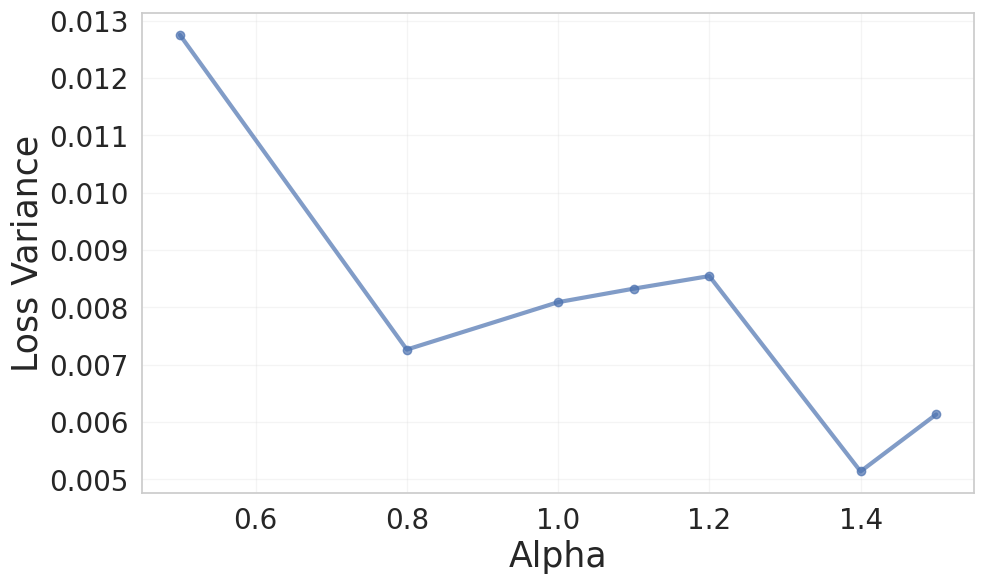

In [54]:
# loss variance
folder_path='/data/home/huq/MLHospital/log_loss_variance/Ours'
# 初始化列表
loss_vars = []
# reg_weights=[0.001,0.0001,0.002,0.0005,0.0007,0.0015,1e-05]
# reg_weights=[0.01,0.001,0.02,0.03,0.003,0.04,0.05,0.005,0.007]
reg_weights=[0.5,0.8,1.0,1.1,1.2,1.4,1.5]
# 遍历文件夹中的文件
for i in reg_weights:
    file_name = f'loss_variance_{i}.pth'
    file_path = os.path.join(folder_path, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_var_tensor = torch.load(file_path)
        loss_vars.append(loss_var_tensor.item())  # 存储为Python标量
        
# loss_gaps=[abs(gap) for gap in loss_gaps]

# 对 reg_weights 和 loss_vars 进行排序
sorted_pairs = sorted(zip(reg_weights, loss_vars), key=lambda x: x[0])
reg_weights_sorted, loss_vars_sorted = zip(*sorted_pairs)

# 绘制曲线图
plt.figure(figsize=(10, 6))
plt.plot(reg_weights_sorted, loss_vars_sorted, marker='o', linestyle='-' ,color='b', label='Loss Variance',linewidth=3,alpha=0.7)
# plt.title('Loss Gap Over Files')
plt.xlabel('Alpha',fontsize=25)
plt.tight_layout()
plt.ylabel('Loss Variance',fontsize=25)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(fontsize=25)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/loss_var_alpha_ours.pdf")

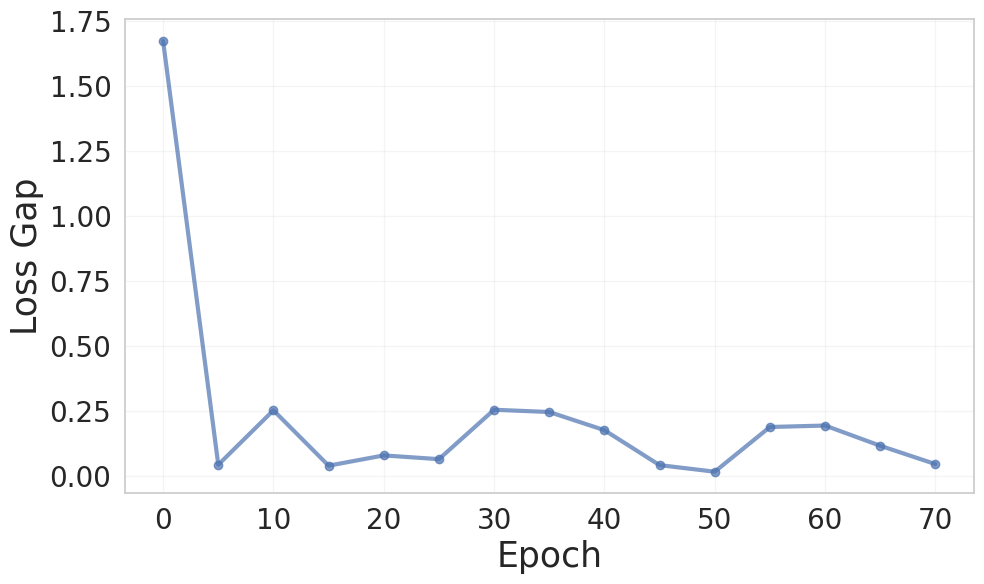

In [66]:
# loss gap-epoch
folder_path='/data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/'
# 初始化列表
loss_gaps = []
# alphas= [0.5,0.8, 1.0,1.1,1.2,1.4, 1.5,1.7, 2.0, 2.5]
alphas=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
# 遍历文件夹中的文件
for i in alphas:
    file_name = f'loss_gap_{i}.pth'
    file_path = os.path.join(folder_path, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_gap_tensor = torch.load(file_path)
        loss_gaps.append(loss_gap_tensor.item())  # 存储为Python标量
        
loss_gaps=[abs(gap) for gap in loss_gaps]

# 绘制曲线图
plt.figure(figsize=(10, 6))
plt.plot(alphas, loss_gaps, marker='o', linestyle='-' ,color='b', label='Loss Gap',linewidth=3,alpha=0.7)
# plt.title('Loss Gap Over Files')
plt.xlabel('Epoch',fontsize=25)
plt.tight_layout()
plt.ylabel('Loss Gap',fontsize=25)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(fontsize=25)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap_epoch.pdf")

# Alpha

In [11]:
# Alpha

import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '../..')))
from mlh.data_preprocessing.data_loader import GetDataLoader
import argparse
torch.manual_seed(0)
np.random.seed(0)
torch.set_num_threads(1)

# args=argparse.Namespace(
#     training_type='Reg-0.001-10050-10000_1.5',
#     dataset='CIFAR10',
#     model='resnet18',
#     data_path='../datasets/',
#     log_path='./save',
#     input_shape="32,32,3"
# )
# args.input_shape = [int(item) for item in args.input_shape.split(',')]

# # 初始化模型、损失函数等
# s = GetDataLoader(args)
# target_train_loader, target_inference_loader, target_test_loader, shadow_train_loader, shadow_inference_loader, shadow_test_loader = s.get_data_supervised()
# member_loader,nonmember_loader=target_train_loader, target_inference_loader

# target_model=torch.load(f'{args.log_path}/{args.dataset}/{args.training_type}/target/{args.model}_model.pth')
# criterion = nn.CrossEntropyLoss()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 初始化 evaluator 并调用
# evaluator = ModelEvaluator(target_model, criterion, device)
# evaluator.evaluate_single_batch(member_loader, nonmember_loader, '/data/home/huq/MLHospital/log_distribution/', training_type=args.training_type)

# 执行函数，遍历不同的训练类型
def main():
    # 设定可变的 training_type 后缀
    # alpha_values = [0.5,0.8, 1.0,1.1,1.2,1.4, 1.5,1.7, 2.0, 2.5]
    alpha_values = [2.0,2.05, 2.1,2.15, 2.2,2.25, 2.3,2.35, 2.4,2.45]

    # 基础的参数设定
    # args = argparse.Namespace(
    #     dataset='CIFAR10',
    #     model='resnet18',
    #     data_path='../datasets/',
    #     log_path='./save',
    #     input_shape="32,32,3"
    # )
    args = argparse.Namespace(
        dataset='CIFAR100',
        model='dense121',
        data_path='../datasets/',
        log_path='./save',
        input_shape="32,32,3"
    )
    args.input_shape = [int(item) for item in args.input_shape.split(',')]

    # 初始化数据加载器
    s = GetDataLoader(args)
    target_train_loader, target_inference_loader, _, _, _, _ = s.get_data_supervised()
    member_loader, nonmember_loader = target_train_loader, target_inference_loader

    # 初始化损失函数和设备
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 迭代不同的 alpha 值，加载不同模型并计算梯度差异
    for alpha in alpha_values:
        # training_type = f'Reg-0.001-10050-10000_{alpha}'
        training_type = f'Reg-0.0001-10020-10000_{alpha}'
        
        # 加载对应的模型
        model_path = f'{args.log_path}/{args.dataset}/{training_type}/target/{args.model}_model.pth'
        if not os.path.exists(model_path):
            print(f"Model not found for {training_type}, skipping...")
            continue
        
        target_model = torch.load(model_path)
        
        # 初始化模型评估器并计算梯度差异
        evaluator = ModelEvaluator(target_model, criterion, device)
        # evaluator.evaluate_single_batch(member_loader, nonmember_loader, '/data/home/huq/MLHospital/log_distribution/grad_gaps_alpha', alpha)
        evaluator.evaluate_single_batch(member_loader, nonmember_loader, '/data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10', alpha)


main()

add simple data augmentation!
add simple data augmentation!
Files already downloaded and verified
Files already downloaded and verified
Preparing dataloader!
dataset:  60000
target_train: 10000 	 target_inference: 10000 	 target_test: 10000
Loss gap gradients for 2.0 saved to /data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/loss_gap_2.0.pth
Model not found for Reg-0.0001-10020-10000_2.05, skipping...
Loss gap gradients for 2.1 saved to /data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/loss_gap_2.1.pth
Model not found for Reg-0.0001-10020-10000_2.15, skipping...
Loss gap gradients for 2.2 saved to /data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/loss_gap_2.2.pth
Loss gap gradients for 2.25 saved to /data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/loss_gap_2.25.pth
Loss gap gradients for 2.3 saved to /data/home/huq/MLHospital/log_distribution/loss_gaps_epoch_cifar10/loss_gap_2.3.pth
Model not found for Reg-0.0001-1002

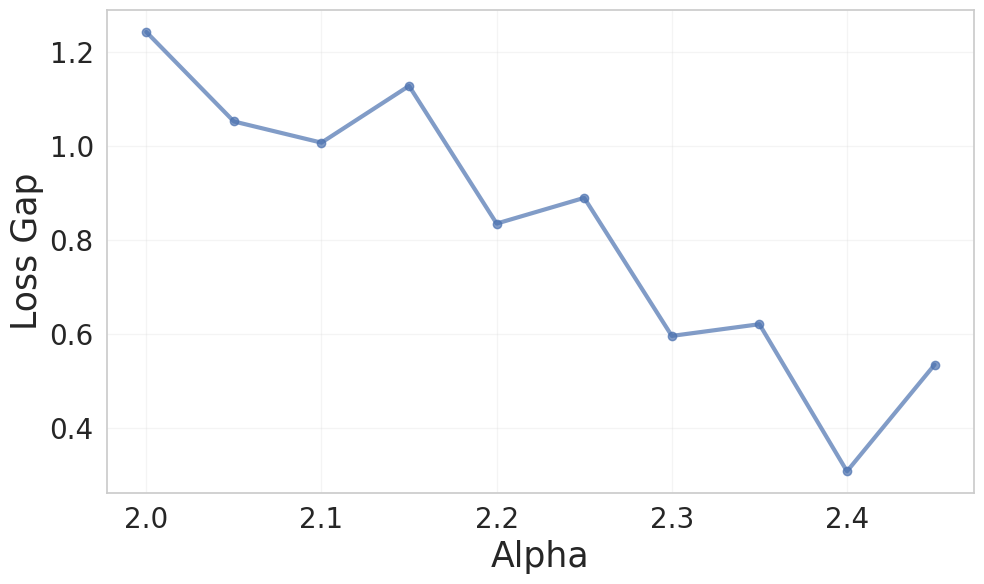

In [65]:
import os
import torch
import matplotlib.pyplot as plt

# 文件夹路径和超参数的取值
grad_gaps_path = '/data/home/huq/MLHospital/log_distribution/grad_gaps_alpha'
# grad_gaps_path = '/data/home/huq/MLHospital/log_distribution/grad_gaps_alpha_cifar100'
alpha_values = [0.5, 1.0, 1.5, 2.0, 2.5]
# alpha_values = [2.0, 2.1, 2.2, 2.3, 2.4]

##############################################################
# # 存储每个超参数的平均 grad gap
# avg_grad_gaps = []

# for alpha in alpha_values:
#     grad_gaps_file = os.path.join(grad_gaps_path, f'grad_gaps_{alpha}.pth')
    
#     if not os.path.exists(grad_gaps_file):
#         print(f"File not found: {grad_gaps_file}")
#         avg_grad_gaps.append(None)
#         continue

#     # 加载 grad gaps
#     grad_gaps = torch.load(grad_gaps_file)
    
#     # 计算所有参数的平均 grad gap
#     total_grad_gap = 0
#     total_params = 0
    
#     for name, grad_gap in grad_gaps.items():
#         if "bn" in name:
#         # print(name)
#             grad_gap_values = grad_gap.cpu().numpy().flatten()  # 转为 numpy 数组并展平
#             total_grad_gap += grad_gap_values.sum()  # 所有参数的 grad gap 总和
#             total_params += len(grad_gap_values)  # 参数总数

#     avg_grad_gap = total_grad_gap / total_params if total_params > 0 else float('nan')
#     avg_grad_gaps.append(avg_grad_gap)

# # 绘制超参数与平均 grad gap 的关系图
# plt.figure(figsize=(10, 6))
# plt.plot(alpha_values, avg_grad_gaps, marker='o', linestyle='-', color='b')
# plt.xlabel('Alpha',fontsize=20)
# plt.ylabel('Mean Grad Gap', fontsize=20)
# # plt.title('Grad Gap 随超参数变化的曲线')
# plt.grid(True)
# plt.xticks(alpha_values)  # 确保 x 轴上显示所有的超参数值
# plt.tight_layout()


# # 保存图像
# plt.savefig('/data/home/huq/MLHospital/figs/grad_gaps_vs_alpha.pdf')
# # plt.savefig('/data/home/huq/MLHospital/figs/grad_gaps_all_vs_alpha_cifar10.pdf')
# plt.show()
# print(avg_grad_gaps)
##############################################################################

folder_path='/data/home/huq/MLHospital/log_distribution/loss_gaps_alpha_cifar100/'
# 初始化列表
loss_gaps = []
# alphas= [0.5,0.8, 1.0,1.1,1.2,1.4, 1.5,1.7, 2.0, 2.5]
alphas=[2.0,2.05, 2.1,2.15, 2.2,2.25, 2.3,2.35, 2.4,2.45]
# 遍历文件夹中的文件
for i in alphas:
    file_name = f'loss_gap_{i}.pth'
    file_path = os.path.join(folder_path, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_gap_tensor = torch.load(file_path)
        loss_gaps.append(loss_gap_tensor.item())  # 存储为Python标量
        
loss_gaps=[abs(gap) for gap in loss_gaps]

# 绘制曲线图
plt.figure(figsize=(10, 6))
plt.plot(alphas, loss_gaps, marker='o', linestyle='-' ,color='b', label='Loss Gap',linewidth=3,alpha=0.7)
# plt.title('Loss Gap Over Files')
plt.xlabel('Alpha',fontsize=25)
plt.tight_layout()
plt.ylabel('Loss Gap',fontsize=25)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(fontsize=25)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap_alpha.pdf")

# Sparsity

Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_0.0/target/resnet18_model.pth
Gini Index for alpha 0.0: 0.0010
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_0.5/target/resnet18_model.pth
Gini Index for alpha 0.5: 0.0244
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_0.8/target/resnet18_model.pth
Gini Index for alpha 0.8: 0.0220
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_1.0/target/resnet18_model.pth
Gini Index for alpha 1.0: 0.0226
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_1.1/target/resnet18_model.pth
Gini Index for alpha 1.1: 0.0242
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_1.2/target/resnet18_model.pth
Gini Index for alpha 1.2: 0.0199
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_1.4/target/resnet18_model.pth
Gini Index for alpha 1.4: 0.0124
Processing model at: ./save/CIFAR10/Reg-0.001-10050-10000_1.5/target/resnet18_model.pth
Gini Index for alpha 1.5: 0.0148
Processing model at: ./save/CIFA

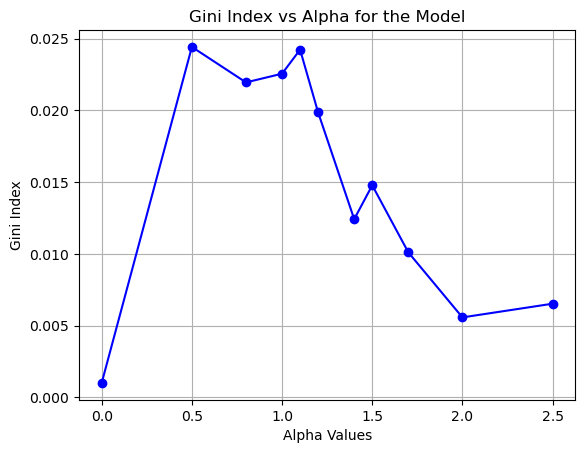

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import argparse

# 计算 Gini 指数的函数
def gini(array):
    """Compute the Gini index of a numpy array."""
    array = np.array(array).flatten()  # Flatten the array to 1D
    if np.amin(array) < 0:
        array -= np.amin(array)  # Ensure non-negative values
    array += 1e-10  # Avoid division by zero
    array = np.sort(array)  # Sort the array
    index = np.arange(1, array.shape[0] + 1)  # Create an index array
    n = array.shape[0]
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

# 对每层计算 Gini 指数
def calculate_gini_per_layer(model):
    gini_indices = {}
    for name, param in model.named_parameters():
        if param.requires_grad:  # 只计算可训练参数
            param_np = param.detach().cpu().numpy().flatten()
            layer_name = name.split('.')[0]  # 提取层名
            if layer_name not in gini_indices:
                gini_indices[layer_name] = []
            gini_indices[layer_name].extend(param_np)  # 合并层内参数
    
    # 对每一层合并后的参数计算 Gini 指数
    gini_per_layer = {layer: gini(np.array(params)) for layer, params in gini_indices.items()}
    
    return gini_per_layer

# 对整个模型计算 Gini 指数
def calculate_gini_for_model(model):
    all_params = []
    for param in model.parameters():
        if param.requires_grad:
            all_params.extend(param.detach().cpu().numpy().flatten())
    
    return gini(np.array(all_params))


# Main 入口
if __name__ == "__main__":
    # 模拟 argparse 参数
    args = argparse.Namespace(
        dataset='CIFAR10',
        model='resnet18',
        data_path='../datasets/',
        log_path='./save',
        input_shape="32,32,3",
        alphas=[0.0, 0.5, 0.8, 1.0, 1.1, 1.2, 1.4, 1.5, 1.7, 2.0, 2.5]  # 假设 alpha 值列表
    )
    args.input_shape = [int(item) for item in args.input_shape.split(',')]

    # 存储 Gini 指数的列表
    gini_indices = []

    # 遍历不同的 alpha 值并计算每个模型的 Gini 指数
    for alpha in args.alphas:
        training_type = f'Reg-0.001-10050-10000_{alpha}'
        
        # 构建模型路径
        model_path = f'{args.log_path}/{args.dataset}/{training_type}/target/{args.model}_model.pth'
        
        # 打印当前模型路径
        print(f"Processing model at: {model_path}")
        
        # 加载模型
        model = torch.load(model_path)
        
        # 计算整个模型的 Gini 指数
        gini_model = calculate_gini_for_model(model)
        gini_indices.append(gini_model)
        print(f"Gini Index for alpha {alpha}: {gini_model:.4f}")

    # 绘制 Gini 指数随 alpha 变化的图
    plt.plot(args.alphas, gini_indices, marker='o', linestyle='-', color='b')
    plt.xlabel('Alpha Values')
    plt.ylabel('Gini Index')
    plt.title('Gini Index vs Alpha for the Model')
    plt.grid(True)
    plt.show()

# Method effect

Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_1.pth
Gini Index for alpha 2.5: 0.0272
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_2.pth
Gini Index for alpha 2.5: 0.0257
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_3.pth
Gini Index for alpha 2.5: 0.0245
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_4.pth
Gini Index for alpha 2.5: 0.0235
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_5.pth
Gini Index for alpha 2.5: 0.0228
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_6.pth
Gini Index for alpha 2.5: 0.0224
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_7.pth
Gini Index for alpha 2.5: 0.0222
Processing model at: /data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_8.pth
Gini Index for alpha 2.5: 0.0222


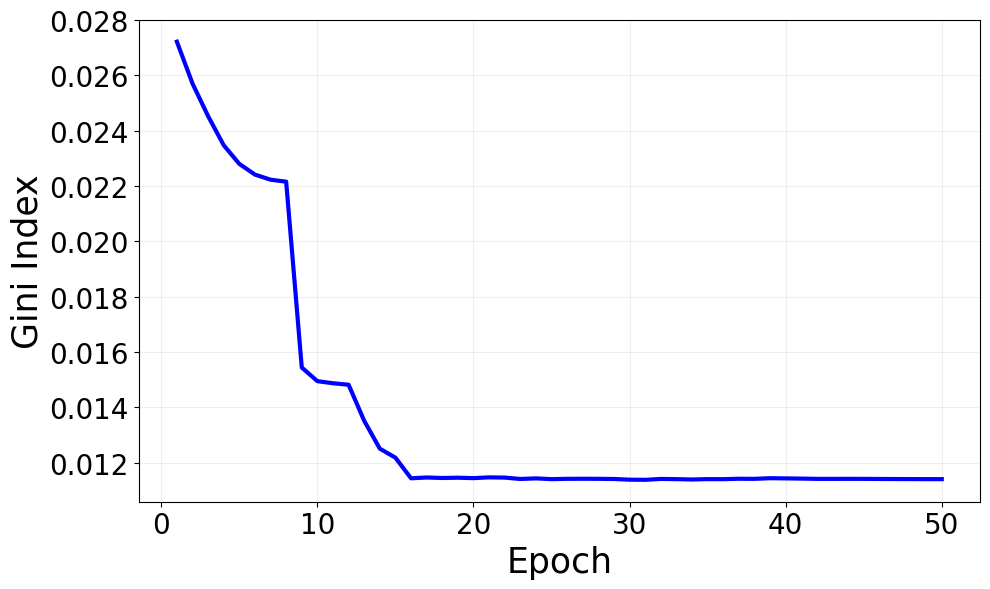

In [44]:
import argparse
# Main 入口
if __name__ == "__main__":
    # 模拟 argparse 参数
    args = argparse.Namespace(
        dataset='CIFAR10',
        model='resnet18',
        data_path='../datasets/',
        log_path='./save',
        input_shape="32,32,3",
        alphas=[0.5, 1.0, 1.5, 2.0, 2.5]  # 假设 alpha 值列表
    )
    args.input_shape = [int(item) for item in args.input_shape.split(',')]

    # 存储 Gini 指数的列表
    gini_indices = []

    # 遍历不同的 alpha 值并计算每个模型的 Gini 指数
    for epoch in range(1,51):
        # training_type = f'Reg-0.001-10050-10000_{alpha}'
        
        # 构建模型路径
        model_path = f'/data/home/huq/MLHospital/log_distribution/model_epochs/resnet18_{epoch}.pth'
        
        # 打印当前模型路径
        print(f"Processing model at: {model_path}")
        
        # 加载模型
        model = torch.load(model_path)
        
        # 计算整个模型的 Gini 指数
        gini_model = calculate_gini_for_model(model)
        gini_indices.append(gini_model)
        print(f"Gini Index for alpha {alpha}: {gini_model:.4f}")

    # 绘制 Gini 指数随 alpha 变化的图
    plt.figure(figsize=(10, 6))
    plt.plot(range(1,51), gini_indices,color='b',label="Ours",linewidth=3)
    plt.xlabel('Epoch',fontsize=25)
    plt.ylabel('Gini Index',fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.title('Gini Index vs Epochs for the Model')
    plt.grid(True,alpha=0.2)
    plt.tight_layout()
    plt.savefig('/data/home/huq/MLHospital/figs/gini_epoch_ours.pdf')
    
    plt.show()

/data/home/huq/.conda/envs/ml-hospital/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


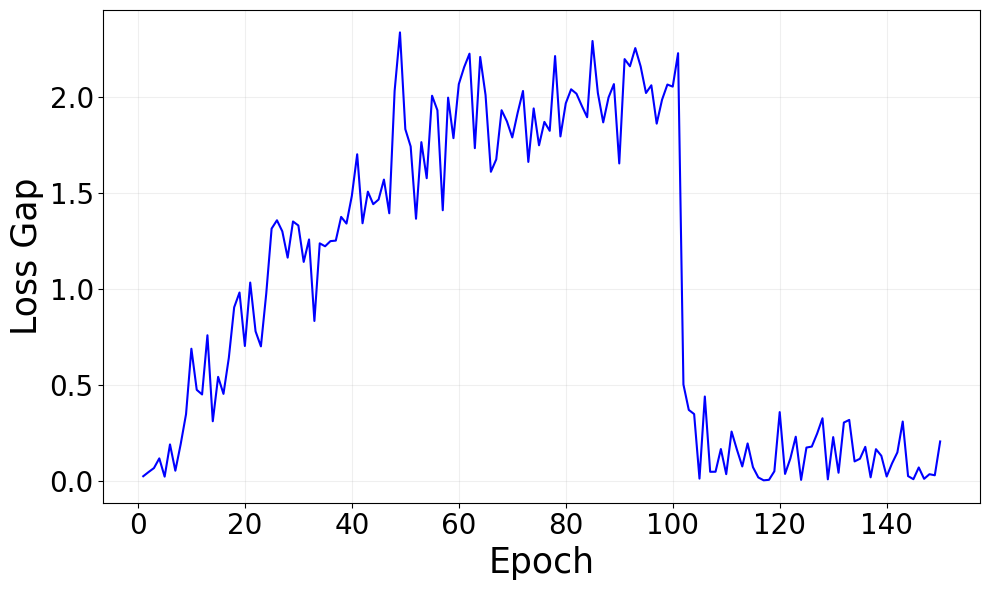

In [1]:
# loss_gap=torch.load("/data/home/huq/MLHospital/log_distribution/loss_gap_grad_noabs_pretrain/loss_gap_100_1.pth")
# print(loss_gap)

import os
import torch
import matplotlib.pyplot as plt

# 设置文件夹路径
folder_path = '/data/home/huq/MLHospital/log_distribution/loss_gap_grad_noabs_pretrain/'
folder_path_finetune = '/data/home/huq/MLHospital/log_distribution/loss_gap_grad_noabs/'

# 初始化列表
loss_gaps = []

# 遍历文件夹中的文件
for i in range(1, 101):
    file_name = f'loss_gap_{i}_1.pth'
    file_path = os.path.join(folder_path, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_gap_tensor = torch.load(file_path)
        loss_gaps.append(loss_gap_tensor.item())  # 存储为Python标量
        
# 遍历文件夹中的文件
for i in range(1, 51):
    file_name = f'loss_gap_{i}_1.pth'
    file_path = os.path.join(folder_path_finetune, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_gap_tensor = torch.load(file_path)
        loss_gaps.append(loss_gap_tensor.item())  # 存储为Python标量

loss_gaps=[abs(gap) for gap in loss_gaps]

# 绘制曲线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, 151), loss_gaps, color='b', label='Loss Gap')
# plt.title('Loss Gap Over Files')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss Gap',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(loc='upper right',fontsize=20)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('/data/home/huq/MLHospital/figs/loss_gap_ours.pdf')
plt.show()

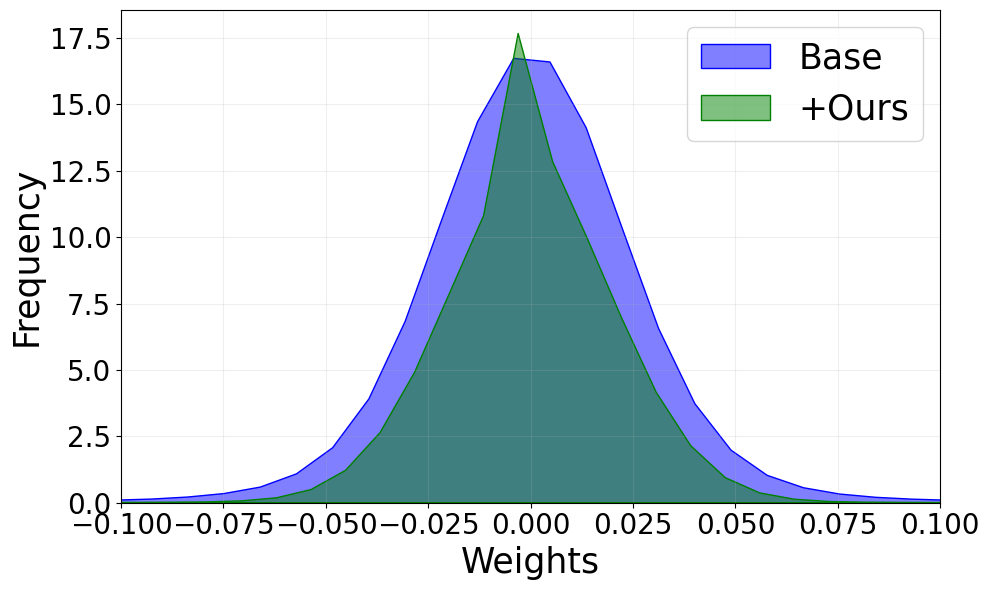

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 加载模型
model_normal = torch.load("/data/home/huq/MLHospital/mlh/examples/save_baseline/CIFAR10/Reg-0.0-0100-10000_0.0/target/resnet18_model.pth")
model_ours = torch.load("/data/home/huq/MLHospital/mlh/examples/save_baseline/CIFAR10/Reg-0.001-10050-10000_1.5/target/resnet18_model.pth")

# 提取权重
weights_normal = []
weights_ours = []

# 提取模型正常权重
for param in model_normal.parameters():
    if param.requires_grad:
        weights_normal.extend(param.data.flatten().tolist())

# 提取我们的模型权重
for param in model_ours.parameters():
    if param.requires_grad:
        weights_ours.extend(param.data.flatten().tolist())

# 绘制直方图
plt.figure(figsize=(10, 6))
# 创建 KDE 图
sns.kdeplot(weights_normal, bw_adjust=1.2, color='b', label='Base', fill=True, alpha=0.5)
sns.kdeplot(weights_ours, bw_adjust=1.2, color='green', label='+Ours', fill=True, alpha=0.5)


# plt.title('Weights Distribution of Two Models')
plt.xlabel('Weights',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.1, 0.1)
# plt.yscale("log")
plt.legend(fontsize=25)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/weight_distribution.pdf")
plt.show()


In [20]:
print(calculate_gini_for_model(model_normal))
print(calculate_gini_for_model(model_ours))

0.031413497363382954
0.014781342978973131


# Motivation

In [16]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '../..')))
from mlh.data_preprocessing.data_loader import GetDataLoader
from mlh.attacks.membership_inference.attacks import AttackDataset, BlackBoxMIA, MetricBasedMIA, LabelOnlyMIA
import argparse
import contextlib
torch.manual_seed(0)
np.random.seed(0)
torch.set_num_threads(1)

args=argparse.Namespace(
    training_type='Reg-0.001-10050-10000_1.5',
    dataset='CIFAR10',
    num_class=10,
    model='resnet18',
    data_path='../datasets/',
    log_path='./save',
    input_shape="32,32,3",
    device='cuda'
)
args.input_shape = [int(item) for item in args.input_shape.split(',')]

# 初始化模型、损失函数等
s = GetDataLoader(args)
target_train_loader, target_inference_loader, target_test_loader, shadow_train_loader, shadow_inference_loader, shadow_test_loader = s.get_data_supervised()
member_loader,nonmember_loader=target_train_loader, target_inference_loader

# 打开文件以写入
with open('metric-based.out', 'w') as f:
    # 重定向标准输出到文件
    with contextlib.redirect_stdout(f):
        for i in range(1,101):
            target_model=torch.load(f'/data/home/huq/MLHospital/log_distribution/loss_gap_mia/target_resnet18_{i}.pth')
            shadow_model=torch.load(f'/data/home/huq/MLHospital/log_distribution/loss_gap_mia/shadow_resnet18_{i}.pth')

            attack_type = "metric-based"
            attack_dataset = AttackDataset(args, attack_type, target_model, shadow_model,
                                                    target_train_loader, target_test_loader, shadow_train_loader, shadow_test_loader)
            attack_model = MetricBasedMIA(
                            num_class=args.num_class,
                            device=args.device,
                            attack_type=attack_type,
                            attack_train_dataset=attack_dataset.attack_train_dataset,
                            attack_test_dataset=attack_dataset.attack_test_dataset,
                            batch_size=128)
            
            # 你可以选择在此处添加其他信息输出
            print(f"Finished iteration {i}\n")  # 例如，这行也会被输出到文件中

add simple data augmentation!
add simple data augmentation!
Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

Preparing dataloader!
dataset:  60000
target_train: 10000 	 target_inference: 10000 	 target_test: 10000


79it [00:02, 34.16it/s]
79it [00:00, 94.34it/s] 
79it [00:00, 106.86it/s]
79it [00:00, 108.26it/s]
79it [00:00, 106.88it/s]
79it [00:00, 103.45it/s]
79it [00:00, 89.75it/s] 
79it [00:00, 106.33it/s]
79it [00:00, 106.34it/s]
79it [00:00, 105.90it/s]
79it [00:00, 107.24it/s]
79it [00:00, 107.11it/s]
79it [00:00, 106.07it/s]
79it [00:00, 106.42it/s]
79it [00:00, 107.63it/s]
79it [00:00, 103.56it/s]
79it [00:00, 104.37it/s]
79it [00:00, 105.85it/s]
79it [00:00, 105.70it/s]
79it [00:00, 107.02it/s]
79it [00:00, 106.43it/s]
79it [00:00, 106.63it/s]
79it [00:00, 107.20it/s]
79it [00:00, 106.26it/s]
79it [00:00, 90.56it/s] 
79it [00:00, 106.18it/s]
79it [00:00, 104.73it/s]
79it [00:00, 106.85it/s]
79it [00:00, 107.21it/s]
79it [00:00, 105.77it/s]
79it [00:00, 91.09it/s] 
79it [00:00, 106.50it/s]
79it [00:00, 103.85it/s]
79it [00:00, 106.62it/s]
79it [00:00, 106.18it/s]
79it [00:00, 91.59it/s] 
79it [00:00, 105.86it/s]
79it [00:00, 107.35it/s]
79it [00:00, 106.13it/s]
79it [00:00, 105.16it/s]
7

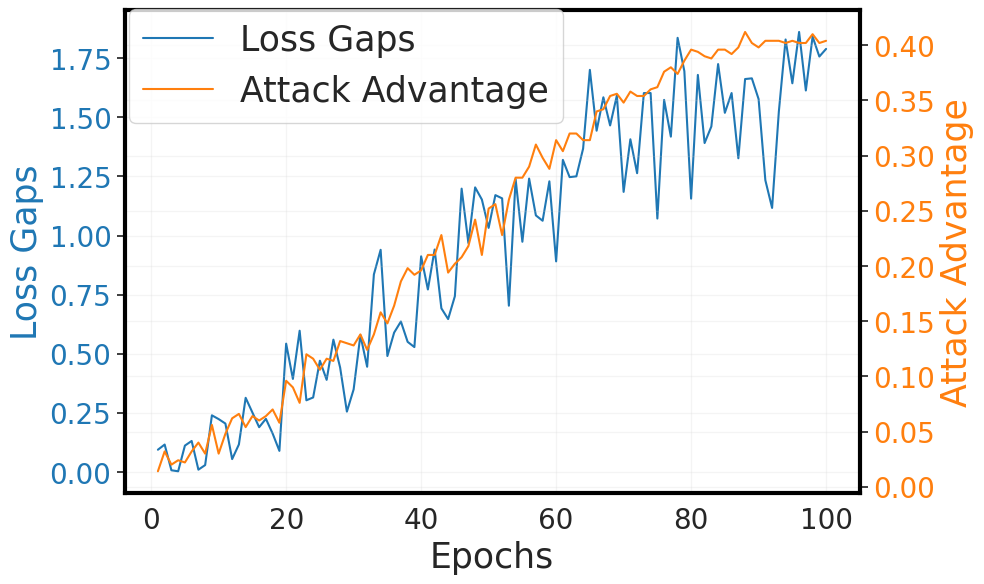

In [27]:
import matplotlib.pyplot as plt


# 定义文件路径
file_path = '/data/home/huq/MLHospital/log_distribution/loss_gap_mia/metric-based.out'

# 读取文件内容
with open(file_path, 'r') as file:
    log_data = file.read()
    
# 提取每个迭代的cross entropy loss test acc
cross_entropy_test_accs = []

# 将日志按行分割
lines = log_data.strip().split('\n')

# 迭代每一行，提取cross entropy loss test acc
for line in lines:
    # 匹配cross entropy loss test acc
    match = re.search(r'cross entropy loss test acc:(\d+\.\d+)', line)
    if match:
        acc_value = 2*float(match.group(1))-1  # 提取的值转为浮点数
        cross_entropy_test_accs.append(acc_value)
        

loss_gap_path="/data/home/huq/MLHospital/log_distribution/loss_gap_mia"

# 初始化列表
loss_gaps = []

# 遍历文件夹中的文件
for i in range(1, 101):
    file_name = f'loss_gap_{i}_1.pth'
    file_path = os.path.join(loss_gap_path, file_name)

    # 读取文件内容
    if os.path.exists(file_path):
        loss_gap_tensor = torch.load(file_path)
        loss_gaps.append(abs(loss_gap_tensor.item()))  # 存储为Python标量
        
        

# 示例数据
epochs = list(range(1, 101))  # 1到100的epochs
# loss_gaps = [...]  # 替换为你的loss_gaps数据
# cross_entropy_test_accs = [...]  # 替换为你的cross_entropy_test_accs数据

fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制loss_gaps曲线
ax1.set_xlabel('Epochs',fontsize=25)
ax1.set_ylabel('Loss Gaps', color='tab:blue', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
line1,=ax1.plot(epochs, loss_gaps, color='tab:blue', label='Loss Gaps')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.grid(alpha=0.2)

# 创建第二个y轴
ax2 = ax1.twinx()
ax2.set_ylabel('Attack Advantage', color='tab:orange', fontsize=25)
plt.yticks(fontsize=20)
line2,=ax2.plot(epochs, cross_entropy_test_accs, color='tab:orange', label='Attack Advantage')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 添加标题和图例
# plt.title('Loss Gaps and Attack Advantage over Epochs')
plt.grid(alpha=0.2)
fig.legend(handles=[line1, line2], loc='upper left', bbox_to_anchor=(0.12, 1), fontsize=25)

# Add a black border around the entire plot
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)

plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')


fig.tight_layout()  # 自动调整布局
plt.savefig("/data/home/huq/MLHospital/figs/loss_gap+attack_adv.pdf")
plt.show()


# Time complexity

/tmp/ipykernel_697054/2475588550.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Defense', y='Time (s)', data=df, palette='viridis')


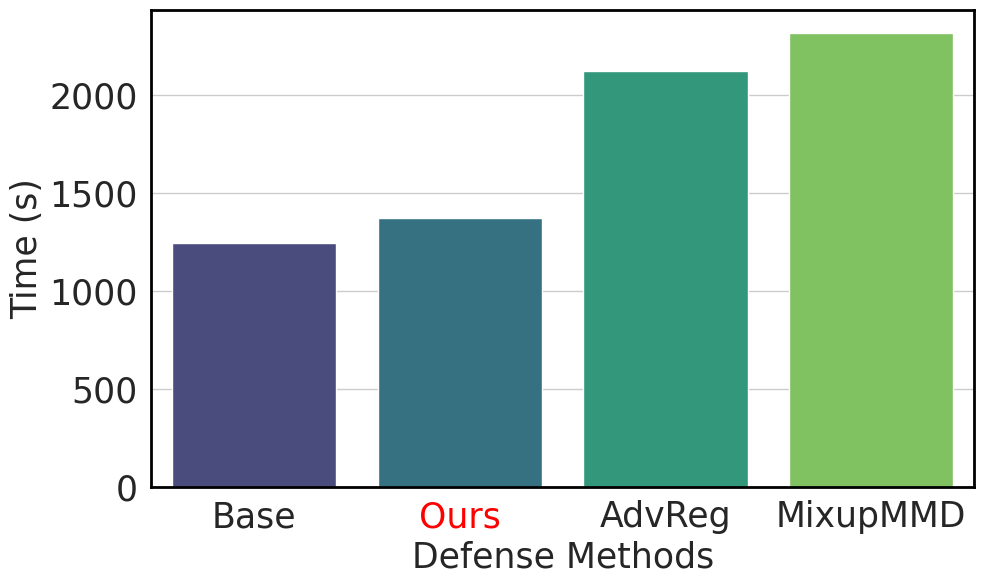

In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Data from the table
# # data = {
# #     'Defense': ['Base', 'AdvReg', 'CCL', 'LabelSmoothing', 'MixupMMD', 'RelaxLoss', 'ConfidencePenalty', 'Dropout', 'L1', 'L2', 'Ours'],
# #     'Time (s)': [1245, 2123, 1243, 1215, 2319, 1214, 1218, 1241, 1231, 1281, 1374]
# # }
# data = {
#     'Defense': ['Base', 'AdvReg', 'MixupMMD', 'Ours'],
#     'Time (s)': [1245, 2123, 2319, 1374]
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Sort the DataFrame by time
# df = df.sort_values(by='Time (s)', ascending=True)

# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Create the bar plot
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(x='Time (s)', y='Defense', data=df, palette='viridis')
# # Highlight 'Ours' in red
# for label in ax.get_yticklabels():
#     if label.get_text() == 'Ours':
#         label.set_color('red')

# # Add titles and labels
# # plt.title('Time Consumption of Various Defense Methods', fontsize=16)
# plt.xlabel('Time (s)', fontsize=25)
# plt.ylabel('Defense Methods', fontsize=25)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# # Show the plot
# plt.tight_layout()
# plt.savefig("/data/home/huq/MLHospital/figs/time_complexity.pdf")
# plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the table
data = {
    'Defense': ['Base', 'AdvReg', 'MixupMMD', 'Ours'],
    'Time (s)': [1245, 2123, 2319, 1374]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by time
df = df.sort_values(by='Time (s)', ascending=True)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the vertical bar plot
plt.figure(figsize=(10, 6))  # Adjusted size for vertical orientation
ax = sns.barplot(x='Defense', y='Time (s)', data=df, palette='viridis')

# Highlight 'Ours' in red
for label in ax.get_xticklabels():
    if label.get_text() == 'Ours':
        label.set_color('red')

# Add titles and labels
plt.xlabel('Defense Methods', fontsize=25)
plt.ylabel('Time (s)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Add a black border around the entire plot
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

# Show the plot
plt.tight_layout()
plt.savefig("/data/home/huq/MLHospital/figs/time_complexity_vertical.pdf")
plt.show()


In [3]:

import torch

model1=torch.load('/data/home/huq/MLHospital/mlh/examples/save/CIFAR10/Reg-0.1-10050-10000_0.5/target/resnet18_model.pth')
model2=torch.load('/data/home/huq/MLHospital/mlh/examples/save/CIFAR10/Reg-0.1-10050-10000_1.0/target/resnet18_model.pth')

# 函数用于打印模型的部分参数
def print_model_parameters(model, num_params=5):
    for name, param in model.named_parameters():
        if param.requires_grad:  # 只打印可训练的参数
            print(f"Parameter name: {name}")
            print(param.data[:num_params])  # 打印前 num_params 个值
            print("------")
            
# 打印两个模型的部分参数
print("Model 1 parameters:")
print_model_parameters(model1)

print("Model 2 parameters:")
print_model_parameters(model2)

Model 1 parameters:
Parameter name: conv1.weight
tensor([[[[ 6.5941e-04, -1.2496e-02,  4.5769e-02,  2.4941e-02,  4.1858e-03,
            4.7441e-03, -1.5686e-03],
          [ 4.3993e-02,  3.2369e-02, -1.4916e-02, -4.3426e-02, -1.6125e-02,
            2.8370e-02,  6.5253e-04],
          [-7.8462e-03,  2.7971e-03, -1.1853e-02, -2.6909e-02, -3.0607e-02,
           -2.7753e-02,  2.9917e-02],
          [-5.5526e-03,  4.1521e-02, -5.6433e-03, -4.1686e-02,  4.4004e-02,
           -2.2852e-02, -1.2704e-03],
          [-1.6189e-02,  1.3332e-02, -6.3006e-02,  4.1081e-02, -6.7020e-02,
           -3.3689e-02,  2.7786e-02],
          [ 2.0387e-02,  1.3054e-02,  1.5144e-03, -3.7664e-02,  5.0781e-02,
           -1.2664e-02,  6.6886e-03],
          [-9.3772e-03, -1.4072e-02,  4.1353e-02,  3.3072e-02, -1.6741e-02,
           -1.6534e-02, -1.1175e-03]],

         [[-2.6581e-02, -2.0679e-03,  7.6277e-04,  1.8570e-02,  1.5626e-02,
           -1.4083e-03, -2.6427e-02],
          [-3.2669e-02, -3.1602e-02, 